## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
from openpyxl.utils import get_column_letter
import json

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-7
EPOCHS = 50
T = 10

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Data Loading

In [3]:
def load_data(*file_paths):
    """
    Returns:
        X (numpy.ndarray): Features array
        y (numpy.ndarray): Labels array
    """
    
    if len(file_paths) == 1:  # Single .npz file
        file_path = file_paths[0]
        
        if not file_path.endswith(".npz"):
            raise ValueError("Single input must be a .npz file")
            
        with np.load(file_path) as data:
            X = data["X"]
            y = data["y"]

    elif len(file_paths) == 2:  # Two .npy files
        x_path, y_path = file_paths
        
        if not (x_path.endswith(".npy") and y_path.endswith(".npy")):
            raise ValueError("When providing two inputs, both must be .npy files")
            
        X = np.load(x_path)
        y = np.load(y_path)

    return X, y

## Checking Distributions

In [4]:
def plot_input_dist(X):
    X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()
    
    for i in range(6):
        axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
        axs[i].set_title(f'Channel {i+1}')
    plt.tight_layout()
    plt.show()


def plot_label_dist(y):
    # Checking the label distribution of training data
    print('\n\n====== Label Distribution ======')
    unique_labels, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
    print("-" * 30)
    for label, count in zip(unique_labels, counts):
        percentage = (count / total) * 100
        print(f"{label:<10}{count:<10}{percentage:<.2f}%")
    
    print(f"\nTotal samples: {total}")
    
    # Plot histogram for training data
    unique_labels, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 4))
    plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title(f"Label Distribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Input Preprocessing

In [5]:
def normalize(X):
    # Standardizing the input features across all timesteps and samples using Z-scores
    # Compute per-feature mean and std across all samples and timesteps
    feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
    feature_stds = X.std(axis=(0, 1))    # Shape: (6,)
    
    # Reshape for broadcasting
    feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
    feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)
    
    # Standardize
    X = ((X - feature_means) / feature_stds).astype(np.float32)
    return X

## Dataset Class

In [6]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Model

In [7]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)
        self.dropout = nn.Dropout(p=0.3)

In [8]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

## Evaluation

In [9]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [10]:
def evaluate(model, dataloader, class_weights=None, T=T, device=DEVICE):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0
    val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, kl = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Loss Calculation
            nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            loss = nll + KL_WEIGHT * kl
            val_loss += loss.item() * x_batch.size(0)
            

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    val_loss /= len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return val_loss, acc, kappa, per_class_f1, avg_f1, cm

## Training

In [11]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [12]:
def train(model, train_dataset, train_dataloader, val_dataset, val_dataloader, class_weights=None, EPOCHS=EPOCHS, T=T):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s, val_per_class_f1s, val_kappas = [], [], []

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    
    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
    
        # === VALIDATION ===
        model.eval()
        val_loss, val_acc, kappa, per_class_f1, avg_f1, _ = evaluate(
            model, val_dataloader, class_weights=class_weights, T=T, device=DEVICE
        )

        scheduler.step(val_loss)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_kappas.append(kappa)
        val_f1s.append(avg_f1)
        val_per_class_f1s.append(per_class_f1)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"F1: {avg_f1:.4f}, Kappa: {kappa:.4f}")  

    return train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s

## Plotting

In [13]:
def plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS):
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(18, 5))  

    # --- Plot Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Plot Validation F1 ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1s, label='Val F1', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Saving Results

In [14]:
def save_results(output_file, history):
    # ensure .xlsx extension
    if not output_file.lower().endswith(".xlsx"):
        output_file = output_file + ".xlsx"

    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for file_name, h in history.items():
            # ---------------------------
            # Per-epoch logs
            # ---------------------------
            df_epochs = pd.DataFrame({
                "epoch": list(range(1, len(h["train_loss"]) + 1)),
                "train_loss": h["train_loss"],
                "train_acc": h["train_acc"],
                "val_loss": h["val_loss"],
                "val_acc": h["val_acc"],
                "val_f1": h["val_f1s"],
                "val_kappa": h["val_kappas"],
                "val_per_class_f1": [
                    ",".join(map(str, f1s)) if f1s is not None else None 
                    for f1s in h["val_per_class_f1s"]
                ]
            })

            # ---------------------------
            # Final test metrics
            # ---------------------------
            final_metrics = {
                "metric": [
                    "overall_loss",
                    "overall_acc",
                    "kappa",
                    "avg_f1",
                    "per_class_f1",
                    "cm"
                ],
                "value": [
                    h["overall_loss"],
                    h["overall_acc"],
                    h["kappa"],
                    h["avg_f1"],
                    ",".join(map(str, h["per_class_f1"])) if h["per_class_f1"] is not None else None,
                    str(h["cm"]) if h["cm"] is not None else None
                ]
            }
            df_final = pd.DataFrame(final_metrics)

            # ---------------------------
            # Write to Excel
            # ---------------------------
            sheet_name = os.path.basename(file_name)[:31]  # Excel sheet name max length = 31
            df_epochs.to_excel(writer, sheet_name=sheet_name, index=False, startrow=0)
            startrow = len(df_epochs) + 2
            df_final.to_excel(writer, sheet_name=sheet_name, index=False, startrow=startrow)

        # ---------------------------
        # Auto-adjust column widths
        # ---------------------------
        for sheet_name, worksheet in writer.sheets.items():
            for col_idx, col_cells in enumerate(worksheet.columns, 1):
                max_length = 0
                col_letter = get_column_letter(col_idx)
                for cell in col_cells:
                    try:
                        if cell.value:
                            max_length = max(max_length, len(str(cell.value)))
                    except:
                        pass
                worksheet.column_dimensions[col_letter].width = max_length + 2

    print(f"Saved history of all files to {output_file}")

In [15]:
def save_history(history, name, output_dir="/kaggle/working"):
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (set, tuple)):
            return list(obj)
        return obj

    # Remove ".npz" if present
    base_name = os.path.basename(name).replace(".npz", "")
    output_file = os.path.join(output_dir, f"{base_name}_history.json")

    with open(output_file, "w") as f:
        json.dump(history, f, default=convert, indent=4)

    print(f'History Dumped in file {output_file}')

## Start

In [16]:
data_dir = "/kaggle/input/data-al"
file_names = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")])
file_names = file_names[4:9]
for name in file_names:
    print(name)
    
X_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy'
y_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy'

/kaggle/input/data-al/data_random.npz
/kaggle/input/data-al/deterministic_CNN_data_diversity.npz
/kaggle/input/data-al/deterministic_CNN_data_entropy.npz
/kaggle/input/data-al/deterministic_CNN_data_entropy_diversity.npz
/kaggle/input/data-al/deterministic_CNN_data_margin.npz


In [17]:
history = {}

for name in file_names:
    history[name] = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [], 
        'val_acc': [],
        'val_f1s': [],
        'val_kappas': [],
        'val_per_class_f1s': [],
        
        'overall_loss': None,
        'overall_acc': None,
        'kappa': None,
        'avg_f1': None,
        'per_class_f1': None,
        'cm': None
    }



====== Loading Data /kaggle/input/data-al/data_random.npz ======
Train Data:  (14000, 28, 6) (14000,)


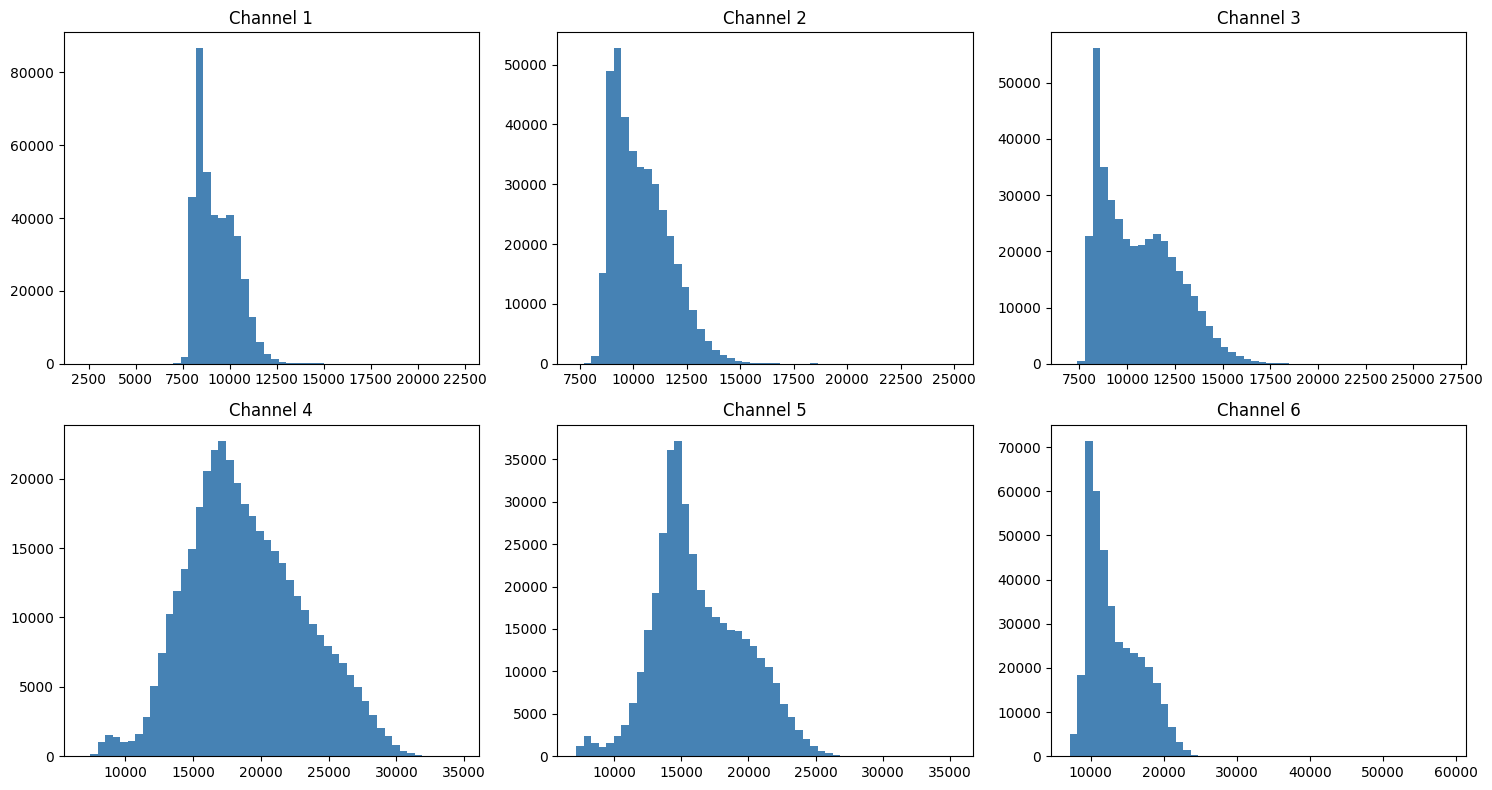

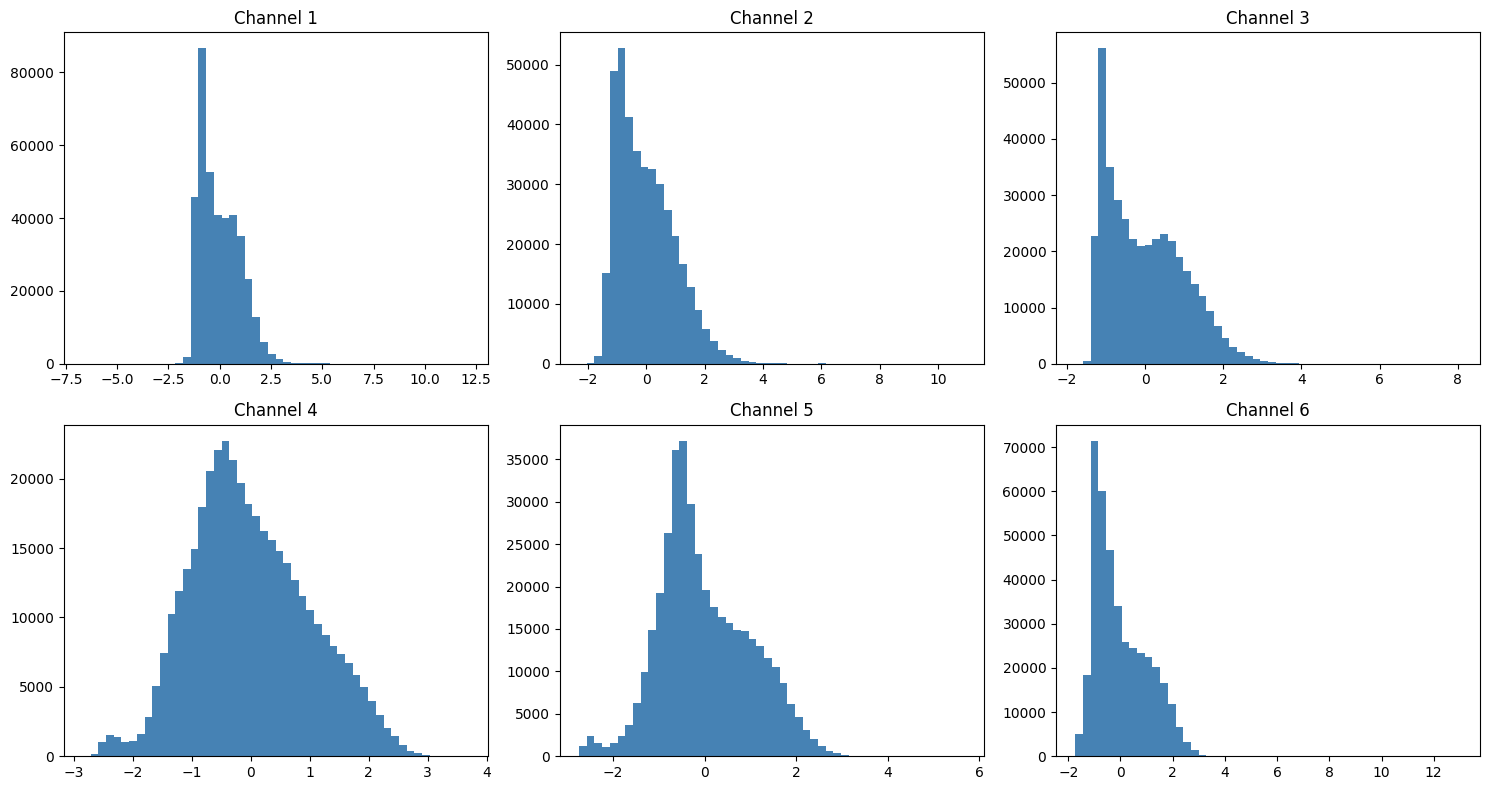



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6266      44.76%
1         2002      14.30%
2         5732      40.94%

Total samples: 14000


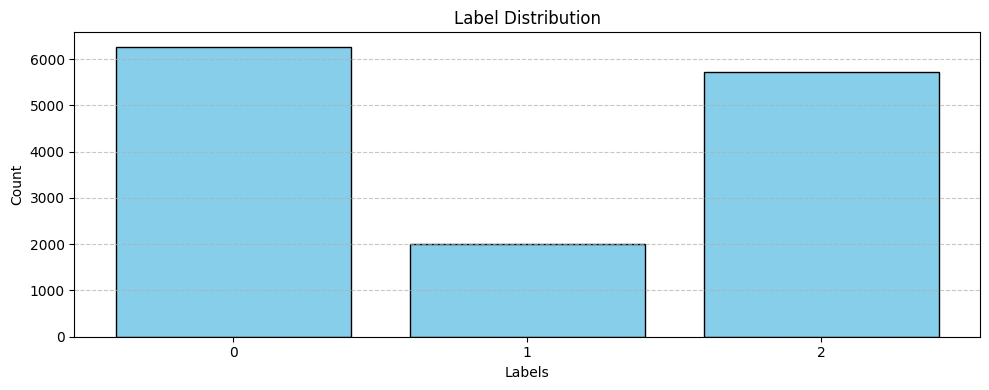


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


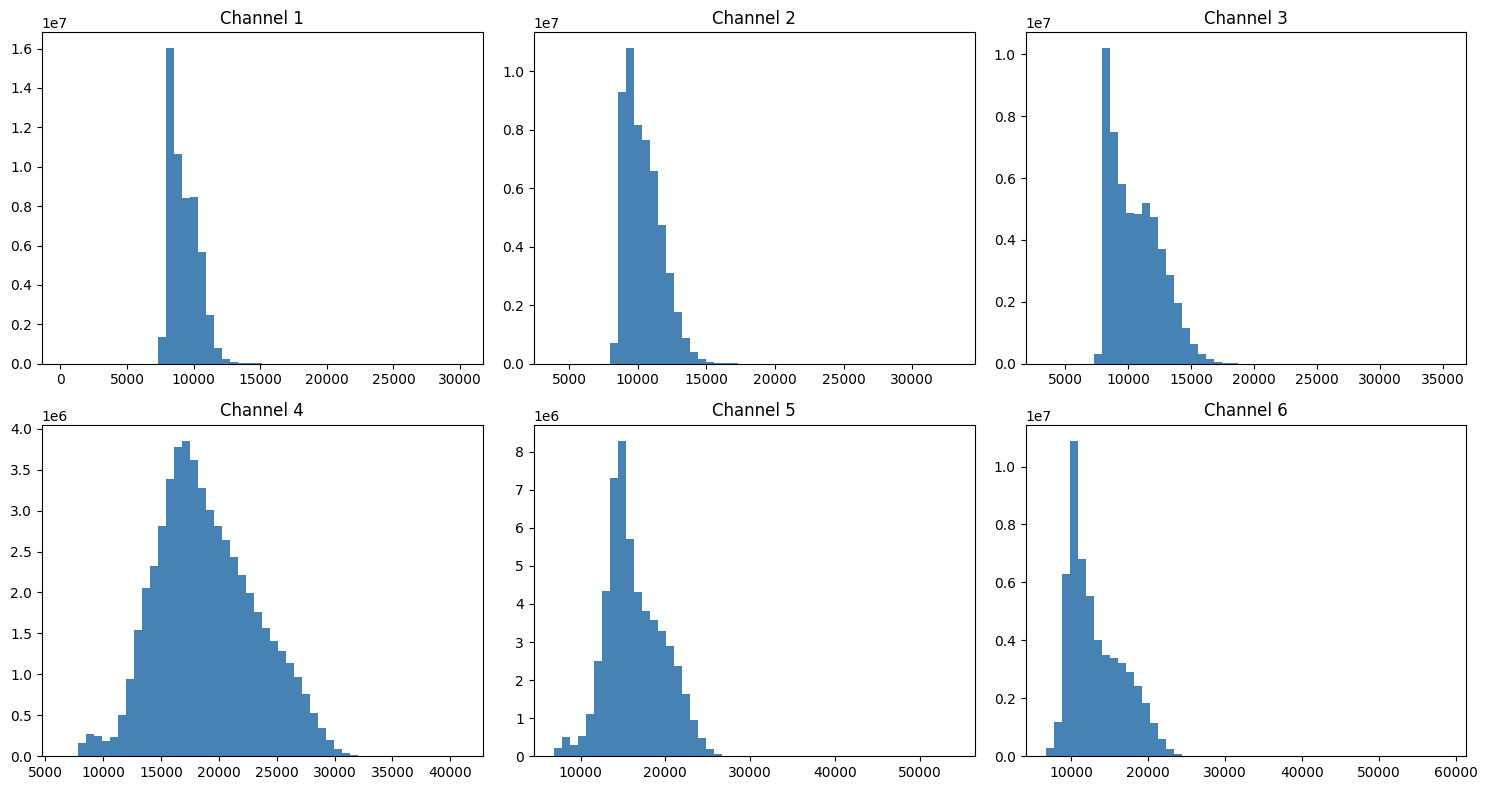

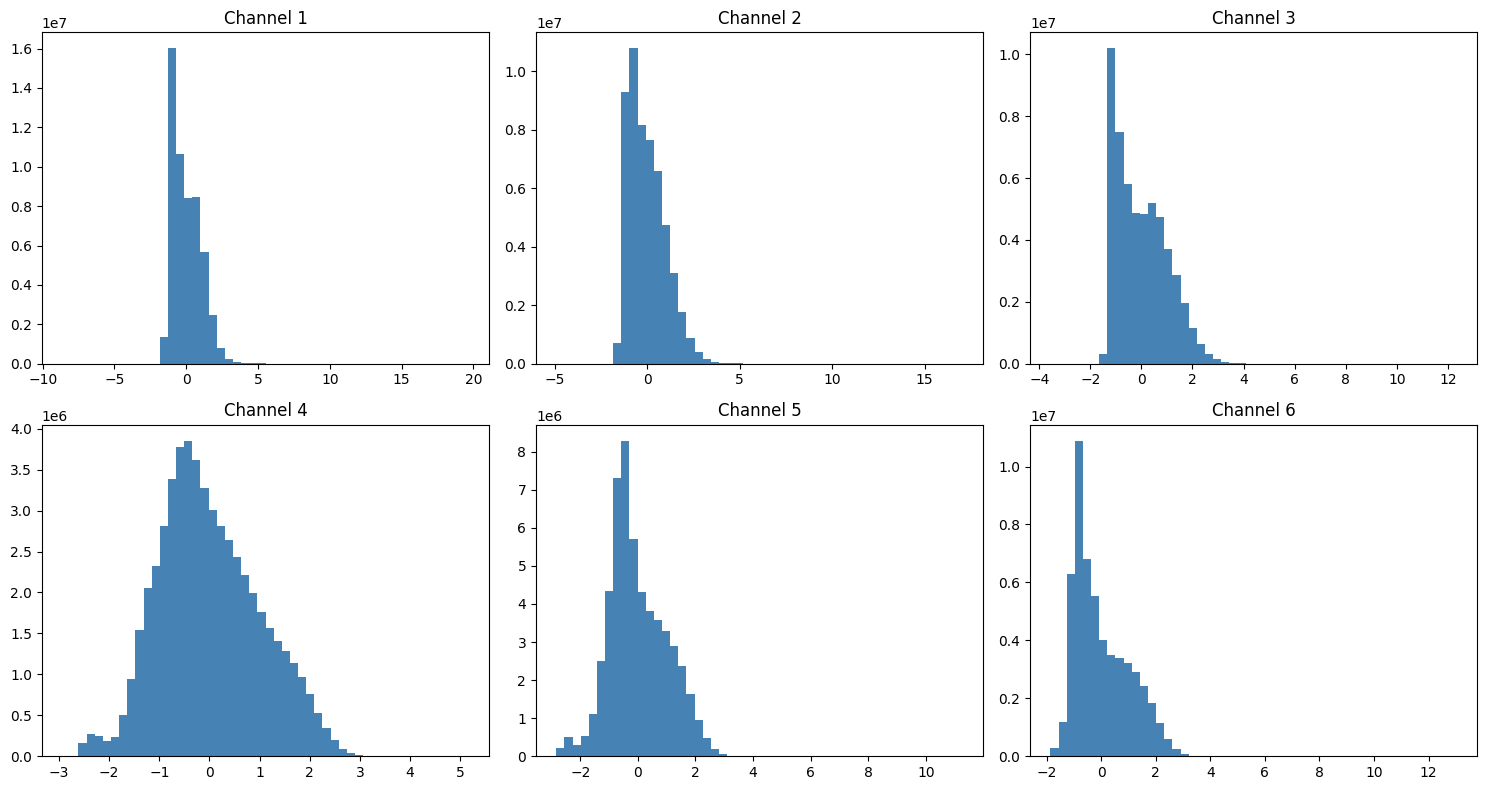



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


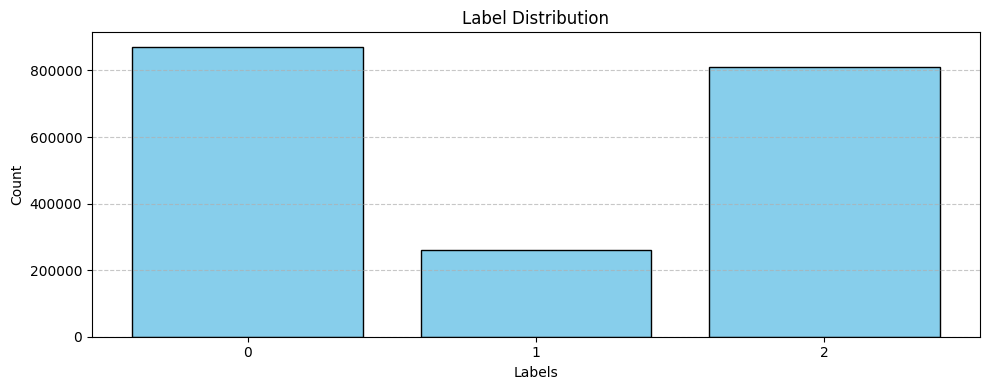

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.7448, 2.3310, 0.8141], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 39.91it/s]


Loss: 0.6276 + 1e-07 * 2658078.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.81it/s]


Epoch [1/50] Train Loss: 0.9253, Train Acc: 0.7205 | Val Loss: 0.5969, Val Acc: 0.8612, F1: 0.8632, Kappa: 0.7725


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.94it/s]


Loss: 0.4251 + 1e-07 * 2434070.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.56it/s]


Epoch [2/50] Train Loss: 0.7137, Train Acc: 0.7872 | Val Loss: 0.5456, Val Acc: 0.8702, F1: 0.8682, Kappa: 0.7882


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.4943 + 1e-07 * 2226321.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.47it/s]


Epoch [3/50] Train Loss: 0.6543, Train Acc: 0.8012 | Val Loss: 0.5068, Val Acc: 0.8805, F1: 0.8801, Kappa: 0.8043


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.3208 + 1e-07 * 2044509.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.80it/s]


Epoch [4/50] Train Loss: 0.6281, Train Acc: 0.8081 | Val Loss: 0.4877, Val Acc: 0.8742, F1: 0.8715, Kappa: 0.7949


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.3669 + 1e-07 * 1885970.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.54it/s]


Epoch [5/50] Train Loss: 0.5959, Train Acc: 0.8081 | Val Loss: 0.4610, Val Acc: 0.8863, F1: 0.8847, Kappa: 0.8138


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.2758 + 1e-07 * 1749153.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.36it/s]


Epoch [6/50] Train Loss: 0.5807, Train Acc: 0.8096 | Val Loss: 0.4430, Val Acc: 0.8830, F1: 0.8816, Kappa: 0.8090


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.3715 + 1e-07 * 1630266.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.35it/s]


Epoch [7/50] Train Loss: 0.5674, Train Acc: 0.8139 | Val Loss: 0.4273, Val Acc: 0.8836, F1: 0.8809, Kappa: 0.8102


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 0.2778 + 1e-07 * 1525159.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.39it/s]


Epoch [8/50] Train Loss: 0.5411, Train Acc: 0.8171 | Val Loss: 0.4142, Val Acc: 0.8869, F1: 0.8834, Kappa: 0.8157


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.4084 + 1e-07 * 1434626.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.23it/s]


Epoch [9/50] Train Loss: 0.5234, Train Acc: 0.8205 | Val Loss: 0.4057, Val Acc: 0.8906, F1: 0.8905, Kappa: 0.8206


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.3668 + 1e-07 * 1352839.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.51it/s]


Epoch [10/50] Train Loss: 0.5121, Train Acc: 0.8207 | Val Loss: 0.3951, Val Acc: 0.8888, F1: 0.8888, Kappa: 0.8179


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.3211 + 1e-07 * 1281871.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.93it/s]


Epoch [11/50] Train Loss: 0.5064, Train Acc: 0.8209 | Val Loss: 0.3868, Val Acc: 0.8873, F1: 0.8827, Kappa: 0.8165


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 0.2132 + 1e-07 * 1219504.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.63it/s]


Epoch [12/50] Train Loss: 0.4923, Train Acc: 0.8196 | Val Loss: 0.3826, Val Acc: 0.8897, F1: 0.8864, Kappa: 0.8200


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.4998 + 1e-07 * 1163909.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.85it/s]


Epoch [13/50] Train Loss: 0.4871, Train Acc: 0.8235 | Val Loss: 0.3869, Val Acc: 0.8847, F1: 0.8808, Kappa: 0.8120


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.3327 + 1e-07 * 1113728.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.19it/s]


Epoch [14/50] Train Loss: 0.4811, Train Acc: 0.8239 | Val Loss: 0.3702, Val Acc: 0.8943, F1: 0.8947, Kappa: 0.8267


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 43.05it/s]


Loss: 0.4822 + 1e-07 * 1067540.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.73it/s]


Epoch [15/50] Train Loss: 0.4660, Train Acc: 0.8303 | Val Loss: 0.3680, Val Acc: 0.8891, F1: 0.8884, Kappa: 0.8185


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.5229 + 1e-07 * 1028147.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.66it/s]


Epoch [16/50] Train Loss: 0.4542, Train Acc: 0.8322 | Val Loss: 0.3639, Val Acc: 0.8901, F1: 0.8873, Kappa: 0.8205


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.99it/s]


Loss: 0.7928 + 1e-07 * 991819.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.63it/s]


Epoch [17/50] Train Loss: 0.4590, Train Acc: 0.8299 | Val Loss: 0.3545, Val Acc: 0.8948, F1: 0.8967, Kappa: 0.8272


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.2462 + 1e-07 * 958615.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.58it/s]


Epoch [18/50] Train Loss: 0.4645, Train Acc: 0.8226 | Val Loss: 0.3484, Val Acc: 0.8946, F1: 0.8923, Kappa: 0.8281


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.4194 + 1e-07 * 929297.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.79it/s]


Epoch [19/50] Train Loss: 0.4548, Train Acc: 0.8300 | Val Loss: 0.3490, Val Acc: 0.8936, F1: 0.8917, Kappa: 0.8262


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.2807 + 1e-07 * 900587.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.30it/s]


Epoch [20/50] Train Loss: 0.4393, Train Acc: 0.8344 | Val Loss: 0.3471, Val Acc: 0.8956, F1: 0.8951, Kappa: 0.8289


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.2915 + 1e-07 * 879034.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.03it/s]


Epoch [21/50] Train Loss: 0.4414, Train Acc: 0.8294 | Val Loss: 0.3481, Val Acc: 0.8935, F1: 0.8947, Kappa: 0.8252


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.88it/s]


Loss: 0.2621 + 1e-07 * 855511.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.90it/s]


Epoch [22/50] Train Loss: 0.4347, Train Acc: 0.8341 | Val Loss: 0.3472, Val Acc: 0.8921, F1: 0.8911, Kappa: 0.8236


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.3584 + 1e-07 * 833791.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.42it/s]


Epoch [23/50] Train Loss: 0.4282, Train Acc: 0.8327 | Val Loss: 0.3497, Val Acc: 0.8868, F1: 0.8846, Kappa: 0.8152


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.2748 + 1e-07 * 813973.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.27it/s]


Epoch [24/50] Train Loss: 0.4335, Train Acc: 0.8312 | Val Loss: 0.3481, Val Acc: 0.8899, F1: 0.8917, Kappa: 0.8196


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.5931 + 1e-07 * 799281.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.39it/s]


Epoch [25/50] Train Loss: 0.4284, Train Acc: 0.8321 | Val Loss: 0.3285, Val Acc: 0.8995, F1: 0.9008, Kappa: 0.8349


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.4590 + 1e-07 * 781207.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.81it/s]


Epoch [26/50] Train Loss: 0.4247, Train Acc: 0.8322 | Val Loss: 0.3289, Val Acc: 0.9001, F1: 0.8991, Kappa: 0.8365


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.3894 + 1e-07 * 764991.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.98it/s]


Epoch [27/50] Train Loss: 0.4217, Train Acc: 0.8319 | Val Loss: 0.3358, Val Acc: 0.8935, F1: 0.8911, Kappa: 0.8262


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.4487 + 1e-07 * 751062.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.80it/s]


Epoch [28/50] Train Loss: 0.4212, Train Acc: 0.8324 | Val Loss: 0.3310, Val Acc: 0.8922, F1: 0.8899, Kappa: 0.8239


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 42.88it/s]


Loss: 0.3074 + 1e-07 * 738291.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.14it/s]


Epoch [29/50] Train Loss: 0.4186, Train Acc: 0.8354 | Val Loss: 0.3238, Val Acc: 0.8975, F1: 0.8950, Kappa: 0.8325


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.3185 + 1e-07 * 725241.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.33it/s]


Epoch [30/50] Train Loss: 0.4162, Train Acc: 0.8311 | Val Loss: 0.3325, Val Acc: 0.8968, F1: 0.8970, Kappa: 0.8307


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.3382 + 1e-07 * 714762.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.05it/s]


Epoch [31/50] Train Loss: 0.4093, Train Acc: 0.8381 | Val Loss: 0.3300, Val Acc: 0.8964, F1: 0.8955, Kappa: 0.8304


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.2740 + 1e-07 * 705009.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.84it/s]


Epoch [32/50] Train Loss: 0.4098, Train Acc: 0.8381 | Val Loss: 0.3287, Val Acc: 0.8963, F1: 0.8953, Kappa: 0.8300


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.3334 + 1e-07 * 695857.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.69it/s]


Epoch [33/50] Train Loss: 0.4173, Train Acc: 0.8344 | Val Loss: 0.3293, Val Acc: 0.8921, F1: 0.8905, Kappa: 0.8236


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.86it/s]


Loss: 0.4481 + 1e-07 * 686066.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.01it/s]


Epoch [34/50] Train Loss: 0.4076, Train Acc: 0.8378 | Val Loss: 0.3267, Val Acc: 0.8934, F1: 0.8911, Kappa: 0.8260


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.2790 + 1e-07 * 678577.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.08it/s]


Epoch [35/50] Train Loss: 0.4102, Train Acc: 0.8374 | Val Loss: 0.3324, Val Acc: 0.8890, F1: 0.8874, Kappa: 0.8187


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.2337 + 1e-07 * 670623.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.84it/s]


Epoch [36/50] Train Loss: 0.3900, Train Acc: 0.8453 | Val Loss: 0.3246, Val Acc: 0.8937, F1: 0.8929, Kappa: 0.8262


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.2508 + 1e-07 * 663329.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.39it/s]


Epoch [37/50] Train Loss: 0.3981, Train Acc: 0.8360 | Val Loss: 0.3214, Val Acc: 0.8993, F1: 0.8993, Kappa: 0.8347


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 43.19it/s]


Loss: 0.2671 + 1e-07 * 656355.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.98it/s]


Epoch [38/50] Train Loss: 0.3961, Train Acc: 0.8394 | Val Loss: 0.3217, Val Acc: 0.8975, F1: 0.8965, Kappa: 0.8321


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.94it/s]


Loss: 0.5187 + 1e-07 * 650718.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.30it/s]


Epoch [39/50] Train Loss: 0.3904, Train Acc: 0.8407 | Val Loss: 0.3252, Val Acc: 0.8982, F1: 0.8992, Kappa: 0.8330


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 43.05it/s]


Loss: 0.1994 + 1e-07 * 644691.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.37it/s]


Epoch [40/50] Train Loss: 0.3882, Train Acc: 0.8399 | Val Loss: 0.3221, Val Acc: 0.8959, F1: 0.8943, Kappa: 0.8297


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 43.21it/s]


Loss: 0.3223 + 1e-07 * 639205.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.63it/s]


Epoch [41/50] Train Loss: 0.3761, Train Acc: 0.8464 | Val Loss: 0.3233, Val Acc: 0.8990, F1: 0.9006, Kappa: 0.8340


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 43.01it/s]


Loss: 0.4867 + 1e-07 * 634182.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.46it/s]


Epoch [42/50] Train Loss: 0.3884, Train Acc: 0.8389 | Val Loss: 0.3254, Val Acc: 0.8974, F1: 0.8970, Kappa: 0.8319


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.2775 + 1e-07 * 629573.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.20it/s]


Epoch [43/50] Train Loss: 0.3828, Train Acc: 0.8436 | Val Loss: 0.3256, Val Acc: 0.8960, F1: 0.8948, Kappa: 0.8298


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.3131 + 1e-07 * 626259.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.72it/s]


Epoch [44/50] Train Loss: 0.3829, Train Acc: 0.8462 | Val Loss: 0.3241, Val Acc: 0.8966, F1: 0.8950, Kappa: 0.8308


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.86it/s]


Loss: 0.3402 + 1e-07 * 623210.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.37it/s]


Epoch [45/50] Train Loss: 0.3866, Train Acc: 0.8404 | Val Loss: 0.3140, Val Acc: 0.8973, F1: 0.8936, Kappa: 0.8323


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.3053 + 1e-07 * 620548.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.73it/s]


Epoch [46/50] Train Loss: 0.3810, Train Acc: 0.8421 | Val Loss: 0.3231, Val Acc: 0.8947, F1: 0.8932, Kappa: 0.8278


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.2932 + 1e-07 * 617601.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.84it/s]


Epoch [47/50] Train Loss: 0.3750, Train Acc: 0.8455 | Val Loss: 0.3307, Val Acc: 0.8965, F1: 0.8954, Kappa: 0.8305


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.1634 + 1e-07 * 614913.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.23it/s]


Epoch [48/50] Train Loss: 0.3736, Train Acc: 0.8433 | Val Loss: 0.3159, Val Acc: 0.8975, F1: 0.8958, Kappa: 0.8324


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.3521 + 1e-07 * 612060.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.48it/s]


Epoch [49/50] Train Loss: 0.3772, Train Acc: 0.8449 | Val Loss: 0.3182, Val Acc: 0.8984, F1: 0.8962, Kappa: 0.8339


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.2397 + 1e-07 * 609397.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.84it/s]


Epoch [50/50] Train Loss: 0.3753, Train Acc: 0.8474 | Val Loss: 0.3234, Val Acc: 0.8960, F1: 0.8945, Kappa: 0.8300


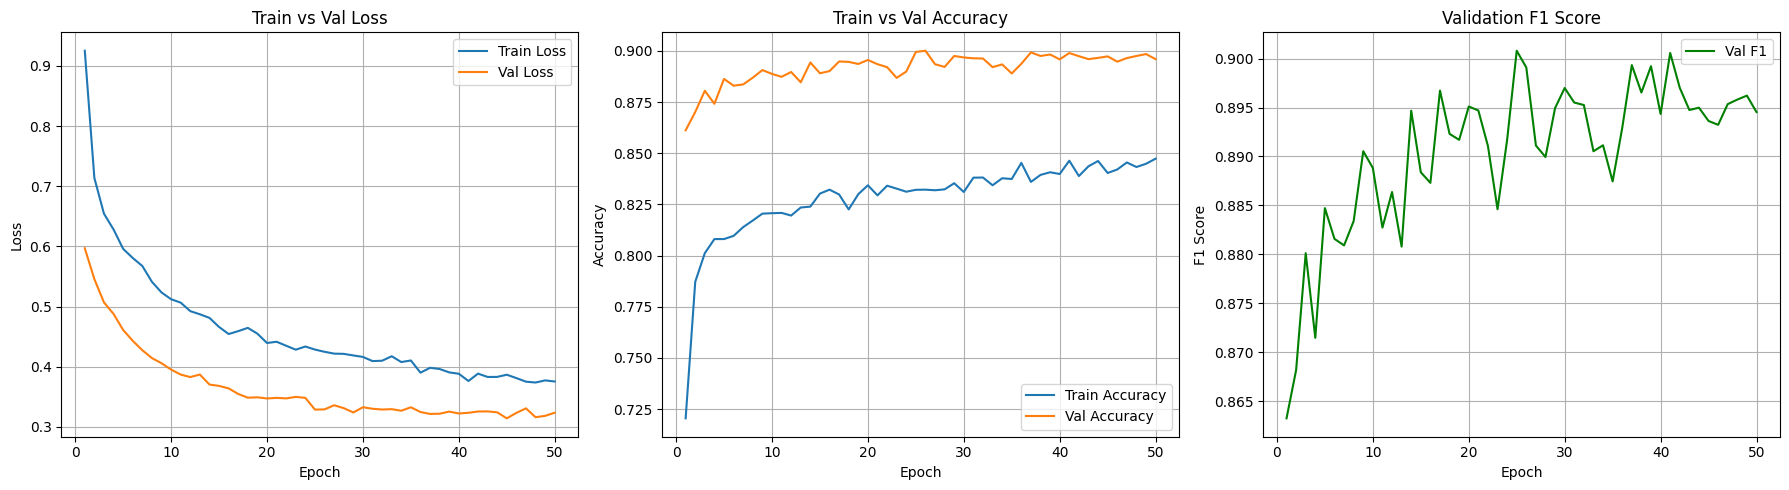


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:41<00:00, 136.70it/s]



====== Test Results ======
Overall Loss: 0.3140
Overall Accuracy: 0.8965
Cohen's Kappa: 0.8307
Per Class F1: [0.89825363 0.89188606 0.89630436]
Macro (Avg) F1: 0.8955


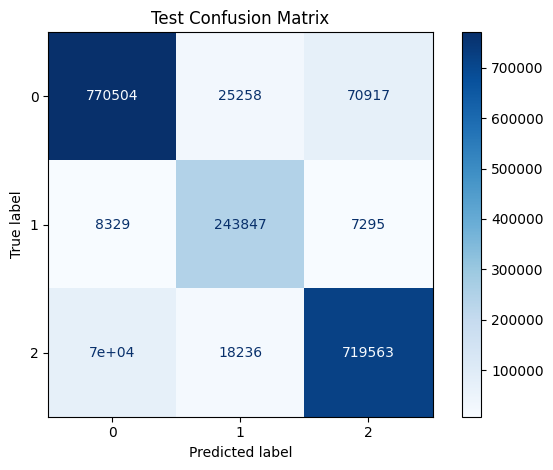

History Dumped in file /kaggle/working/data_random_history.json


====== Loading Data /kaggle/input/data-al/deterministic_CNN_data_diversity.npz ======
Train Data:  (14000, 28, 6) (14000,)


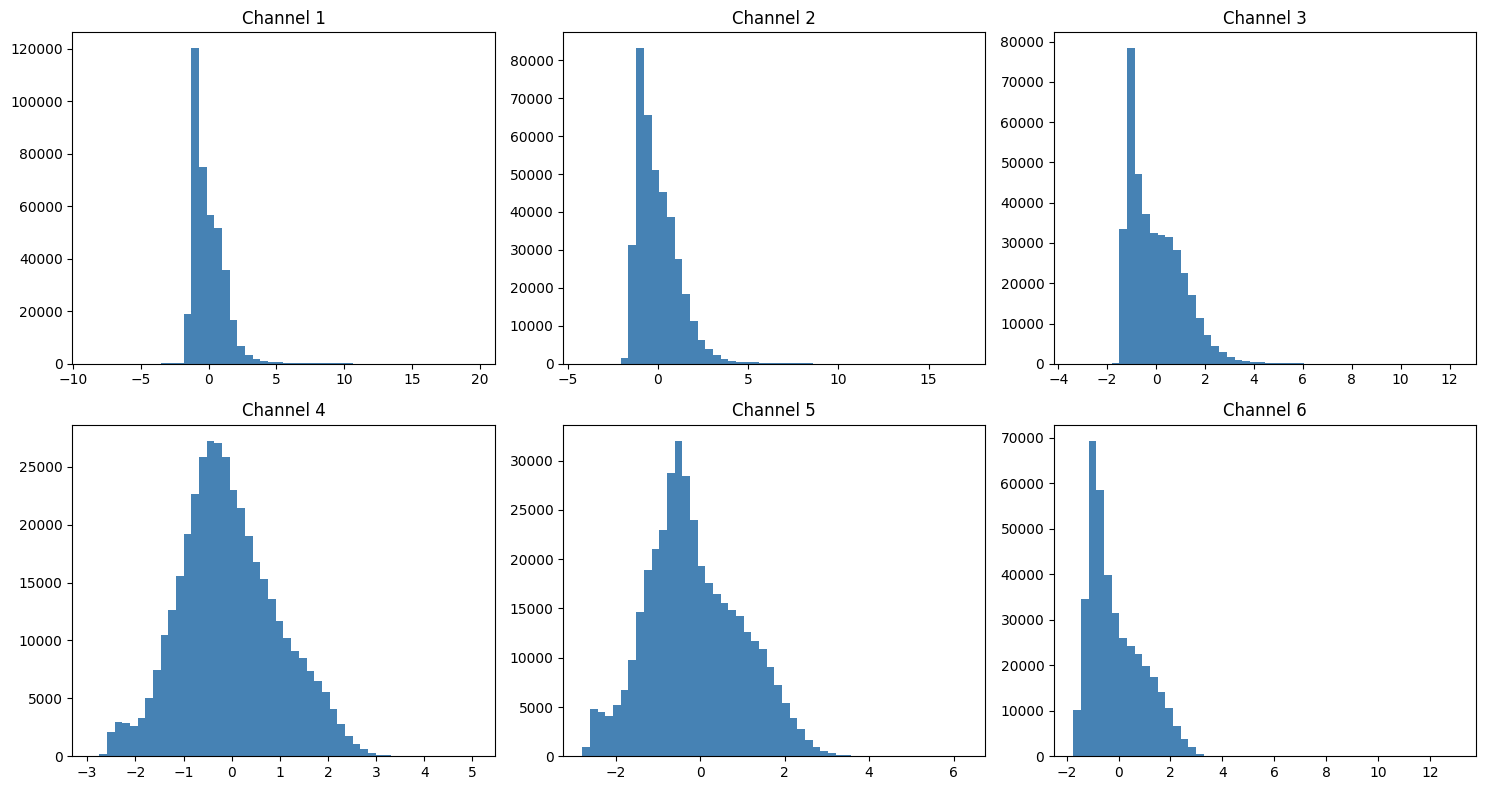

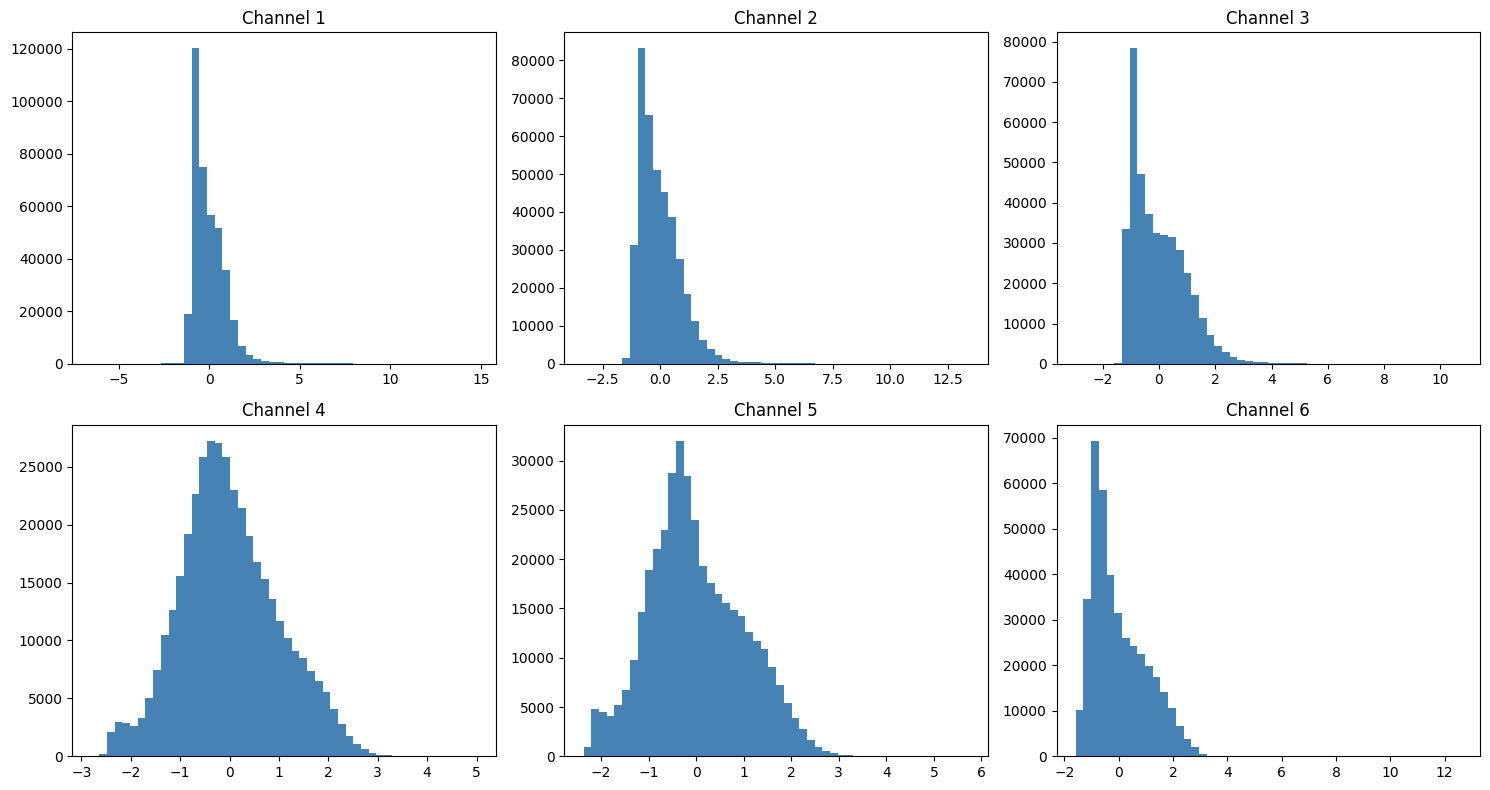



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         7790      55.64%
1         1414      10.10%
2         4796      34.26%

Total samples: 14000


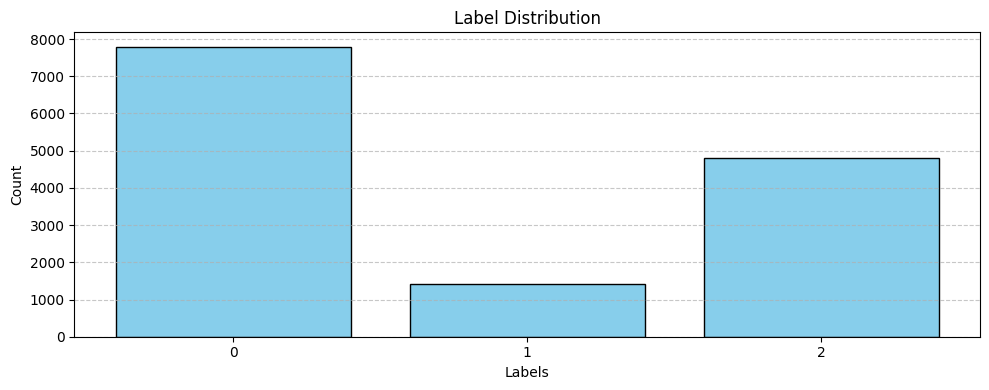


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


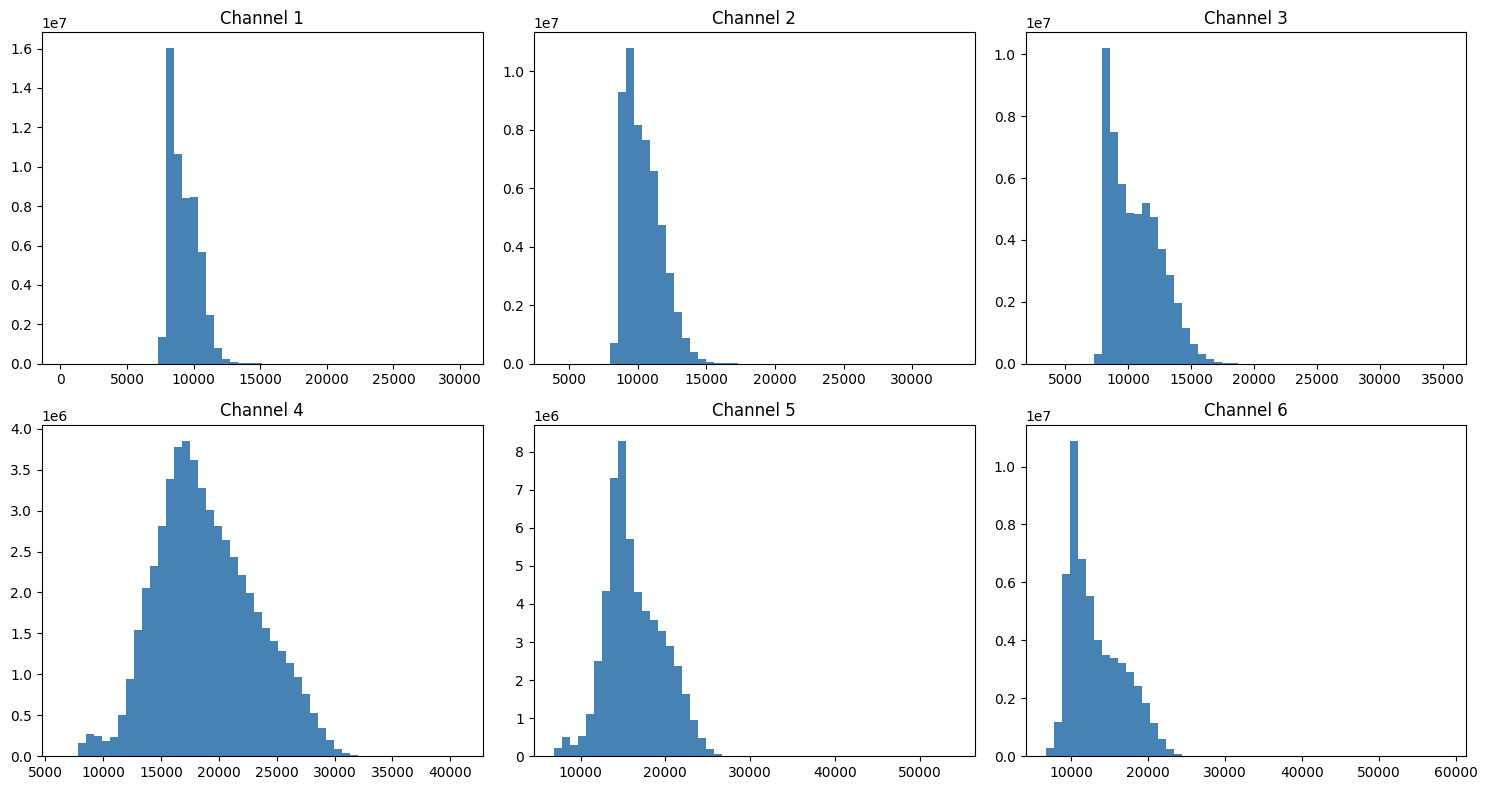

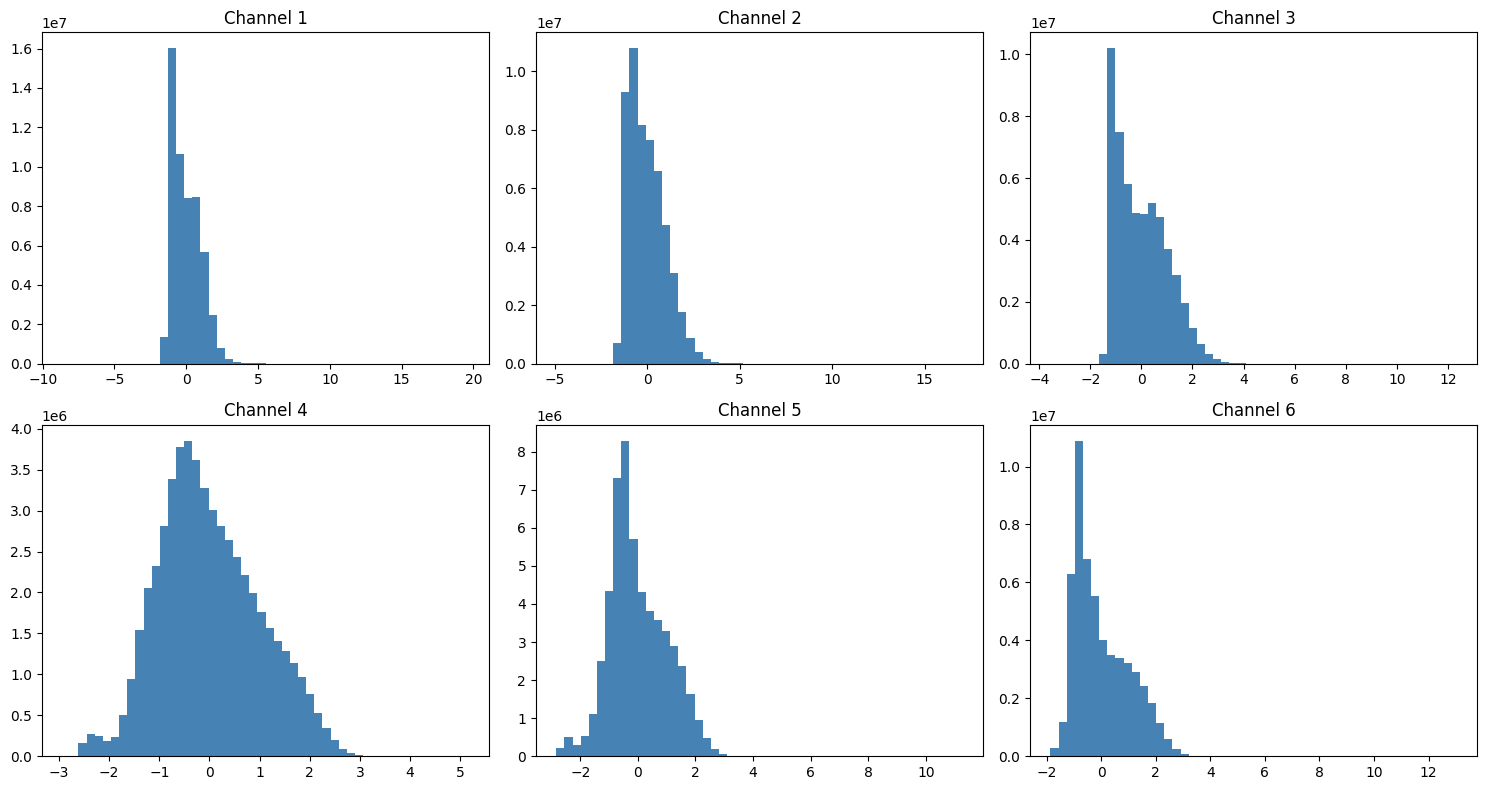



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


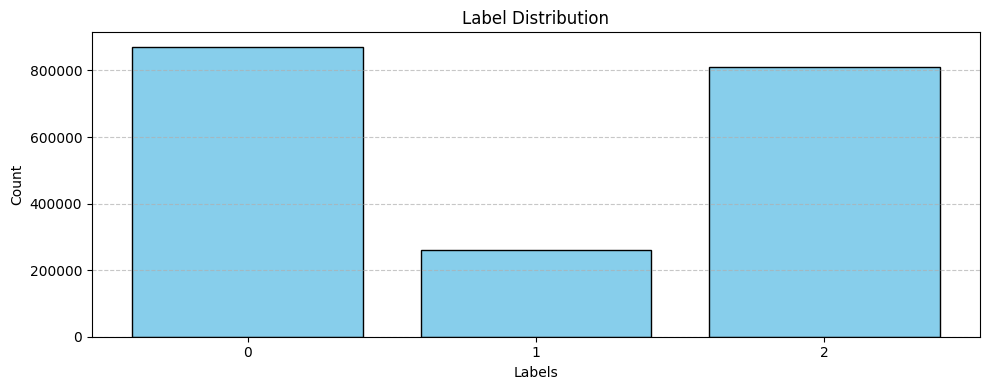

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.5991, 3.3003, 0.9730], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.8933 + 1e-07 * 2697463.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.48it/s]


Epoch [1/50] Train Loss: 1.0691, Train Acc: 0.6841 | Val Loss: 0.6199, Val Acc: 0.8382, F1: 0.8457, Kappa: 0.7353


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.4979 + 1e-07 * 2512011.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.69it/s]


Epoch [2/50] Train Loss: 0.8246, Train Acc: 0.7496 | Val Loss: 0.5666, Val Acc: 0.8505, F1: 0.8539, Kappa: 0.7563


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.7746 + 1e-07 * 2337338.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.26it/s]


Epoch [3/50] Train Loss: 0.7721, Train Acc: 0.7700 | Val Loss: 0.5398, Val Acc: 0.8441, F1: 0.8468, Kappa: 0.7470


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.4897 + 1e-07 * 2181795.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.23it/s]


Epoch [4/50] Train Loss: 0.7383, Train Acc: 0.7776 | Val Loss: 0.5000, Val Acc: 0.8629, F1: 0.8621, Kappa: 0.7774


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.94it/s]


Loss: 0.4575 + 1e-07 * 2040915.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.74it/s]


Epoch [5/50] Train Loss: 0.7059, Train Acc: 0.7859 | Val Loss: 0.4880, Val Acc: 0.8704, F1: 0.8695, Kappa: 0.7889


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 0.4480 + 1e-07 * 1913748.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.50it/s]


Epoch [6/50] Train Loss: 0.6795, Train Acc: 0.7861 | Val Loss: 0.4649, Val Acc: 0.8749, F1: 0.8718, Kappa: 0.7967


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.5318 + 1e-07 * 1800711.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.20it/s]


Epoch [7/50] Train Loss: 0.6563, Train Acc: 0.7981 | Val Loss: 0.4424, Val Acc: 0.8752, F1: 0.8730, Kappa: 0.7971


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 43.11it/s]


Loss: 0.4991 + 1e-07 * 1701142.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.41it/s]


Epoch [8/50] Train Loss: 0.6440, Train Acc: 0.7972 | Val Loss: 0.4350, Val Acc: 0.8763, F1: 0.8751, Kappa: 0.7987


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.4802 + 1e-07 * 1611755.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.32it/s]


Epoch [9/50] Train Loss: 0.6246, Train Acc: 0.8040 | Val Loss: 0.4156, Val Acc: 0.8804, F1: 0.8796, Kappa: 0.8051


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 43.13it/s]


Loss: 0.4086 + 1e-07 * 1531214.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.33it/s]


Epoch [10/50] Train Loss: 0.6047, Train Acc: 0.8051 | Val Loss: 0.4141, Val Acc: 0.8763, F1: 0.8739, Kappa: 0.7990


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.5585 + 1e-07 * 1460922.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.74it/s]


Epoch [11/50] Train Loss: 0.5984, Train Acc: 0.8059 | Val Loss: 0.4219, Val Acc: 0.8743, F1: 0.8708, Kappa: 0.7957


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.7217 + 1e-07 * 1399107.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.48it/s]


Epoch [12/50] Train Loss: 0.5872, Train Acc: 0.8039 | Val Loss: 0.3964, Val Acc: 0.8687, F1: 0.8684, Kappa: 0.7867


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 43.17it/s]


Loss: 0.4449 + 1e-07 * 1340538.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.64it/s]


Epoch [13/50] Train Loss: 0.5676, Train Acc: 0.8119 | Val Loss: 0.4013, Val Acc: 0.8748, F1: 0.8723, Kappa: 0.7965


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 43.05it/s]


Loss: 0.5781 + 1e-07 * 1289648.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.08it/s]


Epoch [14/50] Train Loss: 0.5753, Train Acc: 0.8082 | Val Loss: 0.3944, Val Acc: 0.8769, F1: 0.8718, Kappa: 0.8006


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.6192 + 1e-07 * 1244069.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.84it/s]


Epoch [15/50] Train Loss: 0.5727, Train Acc: 0.8074 | Val Loss: 0.3837, Val Acc: 0.8827, F1: 0.8802, Kappa: 0.8088


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.5770 + 1e-07 * 1200761.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.50it/s]


Epoch [16/50] Train Loss: 0.5590, Train Acc: 0.8094 | Val Loss: 0.3749, Val Acc: 0.8783, F1: 0.8764, Kappa: 0.8020


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.3196 + 1e-07 * 1162383.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.75it/s]


Epoch [17/50] Train Loss: 0.5472, Train Acc: 0.8107 | Val Loss: 0.4027, Val Acc: 0.8643, F1: 0.8607, Kappa: 0.7804


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.7076 + 1e-07 * 1125906.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.95it/s]


Epoch [18/50] Train Loss: 0.5385, Train Acc: 0.8113 | Val Loss: 0.3696, Val Acc: 0.8797, F1: 0.8771, Kappa: 0.8043


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 43.19it/s]


Loss: 0.3929 + 1e-07 * 1094520.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.85it/s]


Epoch [19/50] Train Loss: 0.5267, Train Acc: 0.8104 | Val Loss: 0.3572, Val Acc: 0.8841, F1: 0.8826, Kappa: 0.8112


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.5280 + 1e-07 * 1063199.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.33it/s]


Epoch [20/50] Train Loss: 0.5369, Train Acc: 0.8134 | Val Loss: 0.3652, Val Acc: 0.8764, F1: 0.8784, Kappa: 0.7983


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 43.13it/s]


Loss: 0.2705 + 1e-07 * 1034821.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.69it/s]


Epoch [21/50] Train Loss: 0.5230, Train Acc: 0.8150 | Val Loss: 0.3632, Val Acc: 0.8794, F1: 0.8782, Kappa: 0.8034


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.2753 + 1e-07 * 1010472.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.85it/s]


Epoch [22/50] Train Loss: 0.5294, Train Acc: 0.8136 | Val Loss: 0.3647, Val Acc: 0.8816, F1: 0.8776, Kappa: 0.8076


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.6153 + 1e-07 * 988220.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.01it/s]


Epoch [23/50] Train Loss: 0.5133, Train Acc: 0.8160 | Val Loss: 0.3606, Val Acc: 0.8887, F1: 0.8883, Kappa: 0.8181


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 43.12it/s]


Loss: 0.3746 + 1e-07 * 966309.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.22it/s]


Epoch [24/50] Train Loss: 0.5086, Train Acc: 0.8226 | Val Loss: 0.3487, Val Acc: 0.8903, F1: 0.8884, Kappa: 0.8212


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 43.14it/s]


Loss: 0.3924 + 1e-07 * 944910.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.13it/s]


Epoch [25/50] Train Loss: 0.5025, Train Acc: 0.8219 | Val Loss: 0.3379, Val Acc: 0.8820, F1: 0.8815, Kappa: 0.8078


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 43.29it/s]


Loss: 0.3774 + 1e-07 * 927068.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.10it/s]


Epoch [26/50] Train Loss: 0.5024, Train Acc: 0.8200 | Val Loss: 0.3714, Val Acc: 0.8649, F1: 0.8702, Kappa: 0.7792


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 43.09it/s]


Loss: 0.6551 + 1e-07 * 908592.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.92it/s]


Epoch [27/50] Train Loss: 0.4997, Train Acc: 0.8229 | Val Loss: 0.3407, Val Acc: 0.8874, F1: 0.8887, Kappa: 0.8159


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.3472 + 1e-07 * 892144.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.59it/s]


Epoch [28/50] Train Loss: 0.4983, Train Acc: 0.8195 | Val Loss: 0.3475, Val Acc: 0.8834, F1: 0.8822, Kappa: 0.8100


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 0.4297 + 1e-07 * 877875.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.55it/s]


Epoch [29/50] Train Loss: 0.4986, Train Acc: 0.8200 | Val Loss: 0.3383, Val Acc: 0.8793, F1: 0.8769, Kappa: 0.8042


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.3584 + 1e-07 * 864246.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.80it/s]


Epoch [30/50] Train Loss: 0.4900, Train Acc: 0.8215 | Val Loss: 0.3491, Val Acc: 0.8844, F1: 0.8845, Kappa: 0.8112


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.4763 + 1e-07 * 850967.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.83it/s]


Epoch [31/50] Train Loss: 0.4911, Train Acc: 0.8239 | Val Loss: 0.3310, Val Acc: 0.8871, F1: 0.8844, Kappa: 0.8163


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 43.24it/s]


Loss: 0.3788 + 1e-07 * 838708.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.30it/s]


Epoch [32/50] Train Loss: 0.4770, Train Acc: 0.8269 | Val Loss: 0.3355, Val Acc: 0.8831, F1: 0.8842, Kappa: 0.8090


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 43.01it/s]


Loss: 0.4298 + 1e-07 * 828796.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.52it/s]


Epoch [33/50] Train Loss: 0.4777, Train Acc: 0.8270 | Val Loss: 0.3544, Val Acc: 0.8791, F1: 0.8787, Kappa: 0.8028


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 43.13it/s]


Loss: 0.4027 + 1e-07 * 817853.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.26it/s]


Epoch [34/50] Train Loss: 0.4810, Train Acc: 0.8244 | Val Loss: 0.3407, Val Acc: 0.8790, F1: 0.8784, Kappa: 0.8031


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.2956 + 1e-07 * 806692.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.69it/s]


Epoch [35/50] Train Loss: 0.4759, Train Acc: 0.8241 | Val Loss: 0.3353, Val Acc: 0.8860, F1: 0.8843, Kappa: 0.8141


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 43.13it/s]


Loss: 0.5692 + 1e-07 * 796774.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.30it/s]


Epoch [36/50] Train Loss: 0.4657, Train Acc: 0.8304 | Val Loss: 0.3396, Val Acc: 0.8792, F1: 0.8781, Kappa: 0.8032


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.5151 + 1e-07 * 788636.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.37it/s]


Epoch [37/50] Train Loss: 0.4738, Train Acc: 0.8274 | Val Loss: 0.3390, Val Acc: 0.8793, F1: 0.8763, Kappa: 0.8043


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.6356 + 1e-07 * 780677.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.06it/s]


Epoch [38/50] Train Loss: 0.4602, Train Acc: 0.8264 | Val Loss: 0.3387, Val Acc: 0.8821, F1: 0.8812, Kappa: 0.8078


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 43.12it/s]


Loss: 0.3530 + 1e-07 * 773557.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.11it/s]


Epoch [39/50] Train Loss: 0.4662, Train Acc: 0.8286 | Val Loss: 0.3359, Val Acc: 0.8855, F1: 0.8846, Kappa: 0.8133


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 43.20it/s]


Loss: 0.2838 + 1e-07 * 766385.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.11it/s]


Epoch [40/50] Train Loss: 0.4497, Train Acc: 0.8339 | Val Loss: 0.3318, Val Acc: 0.8804, F1: 0.8816, Kappa: 0.8049


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.3173 + 1e-07 * 759890.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.60it/s]


Epoch [41/50] Train Loss: 0.4548, Train Acc: 0.8331 | Val Loss: 0.3334, Val Acc: 0.8821, F1: 0.8829, Kappa: 0.8077


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 43.12it/s]


Loss: 0.4262 + 1e-07 * 753723.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.81it/s]


Epoch [42/50] Train Loss: 0.4601, Train Acc: 0.8244 | Val Loss: 0.3369, Val Acc: 0.8830, F1: 0.8795, Kappa: 0.8097


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.3373 + 1e-07 * 747609.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.82it/s]


Epoch [43/50] Train Loss: 0.4587, Train Acc: 0.8289 | Val Loss: 0.3261, Val Acc: 0.8840, F1: 0.8847, Kappa: 0.8108


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.3303 + 1e-07 * 742708.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.40it/s]


Epoch [44/50] Train Loss: 0.4525, Train Acc: 0.8308 | Val Loss: 0.3391, Val Acc: 0.8840, F1: 0.8831, Kappa: 0.8109


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.5232 + 1e-07 * 737725.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.38it/s]


Epoch [45/50] Train Loss: 0.4423, Train Acc: 0.8316 | Val Loss: 0.3284, Val Acc: 0.8894, F1: 0.8889, Kappa: 0.8193


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 43.14it/s]


Loss: 0.3110 + 1e-07 * 733082.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.83it/s]


Epoch [46/50] Train Loss: 0.4477, Train Acc: 0.8318 | Val Loss: 0.3352, Val Acc: 0.8796, F1: 0.8776, Kappa: 0.8039


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.2291 + 1e-07 * 728445.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.95it/s]


Epoch [47/50] Train Loss: 0.4481, Train Acc: 0.8343 | Val Loss: 0.3325, Val Acc: 0.8887, F1: 0.8882, Kappa: 0.8181


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.3137 + 1e-07 * 723716.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.51it/s]


Epoch [48/50] Train Loss: 0.4370, Train Acc: 0.8381 | Val Loss: 0.3371, Val Acc: 0.8758, F1: 0.8758, Kappa: 0.7978


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.1806 + 1e-07 * 719691.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.12it/s]


Epoch [49/50] Train Loss: 0.4500, Train Acc: 0.8297 | Val Loss: 0.3286, Val Acc: 0.8875, F1: 0.8862, Kappa: 0.8163


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 43.19it/s]


Loss: 0.4228 + 1e-07 * 716579.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.86it/s]


Epoch [50/50] Train Loss: 0.4393, Train Acc: 0.8351 | Val Loss: 0.3302, Val Acc: 0.8817, F1: 0.8828, Kappa: 0.8069


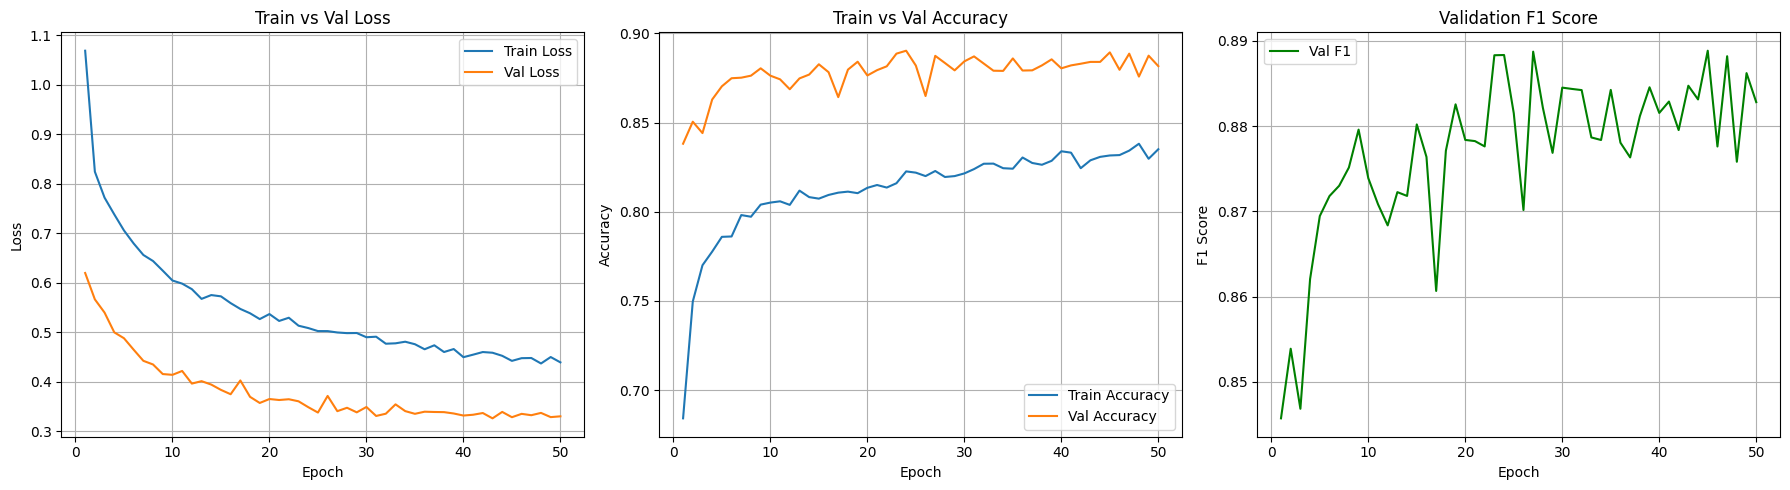


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:40<00:00, 136.96it/s]



====== Test Results ======
Overall Loss: 0.3386
Overall Accuracy: 0.8868
Cohen's Kappa: 0.8149
Per Class F1: [0.8836959  0.89001629 0.88900598]
Macro (Avg) F1: 0.8876


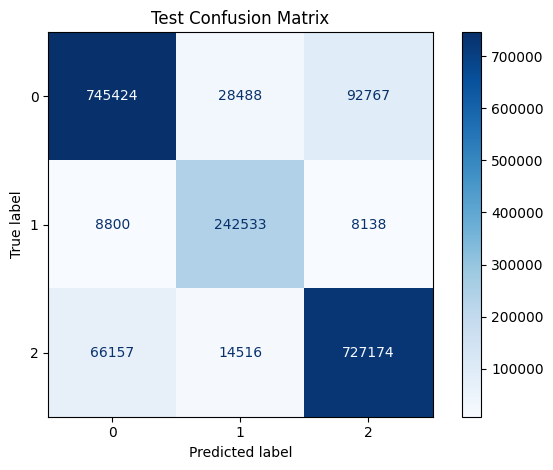

History Dumped in file /kaggle/working/deterministic_CNN_data_diversity_history.json


====== Loading Data /kaggle/input/data-al/deterministic_CNN_data_entropy.npz ======
Train Data:  (14000, 28, 6) (14000,)


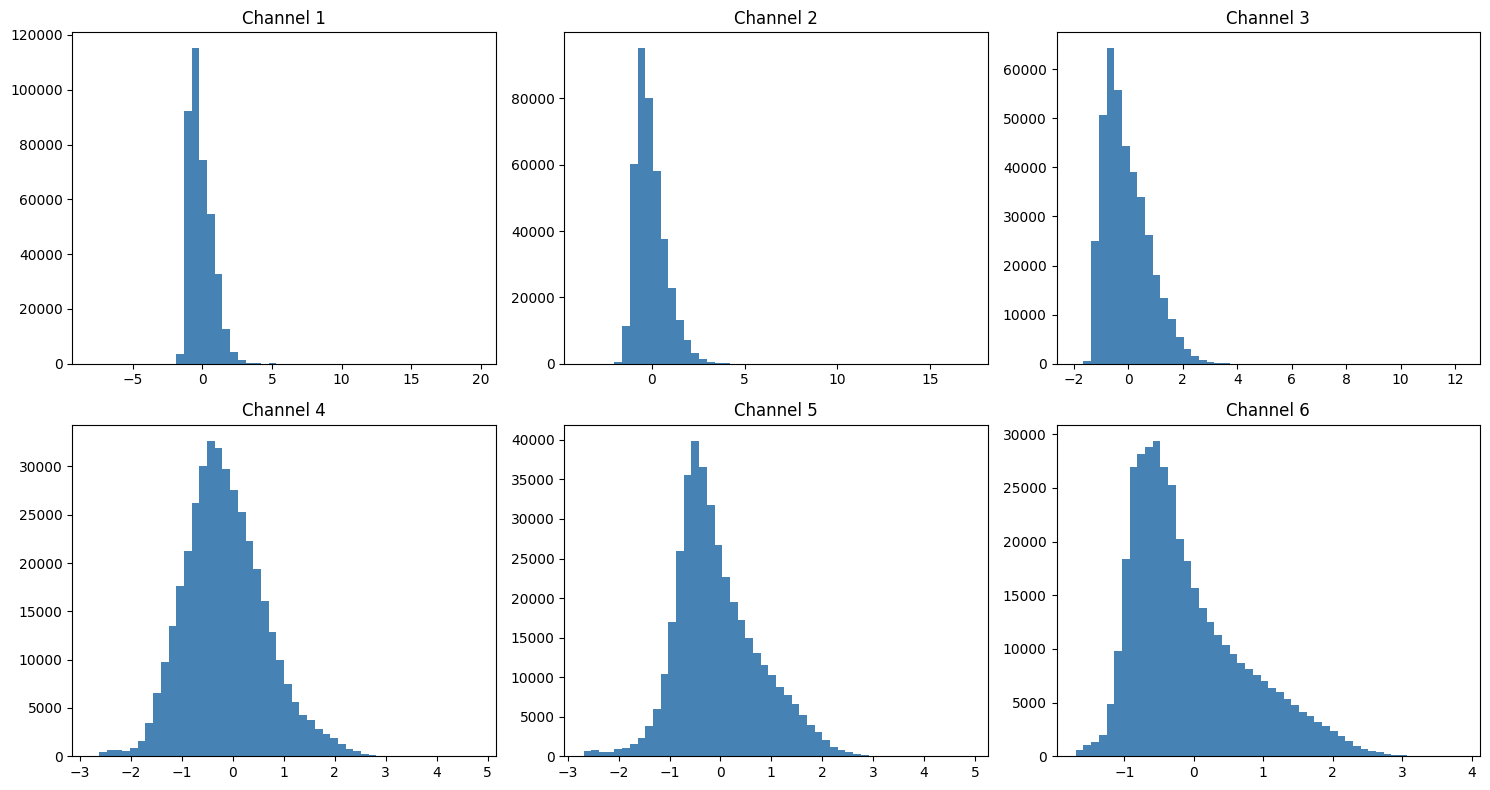

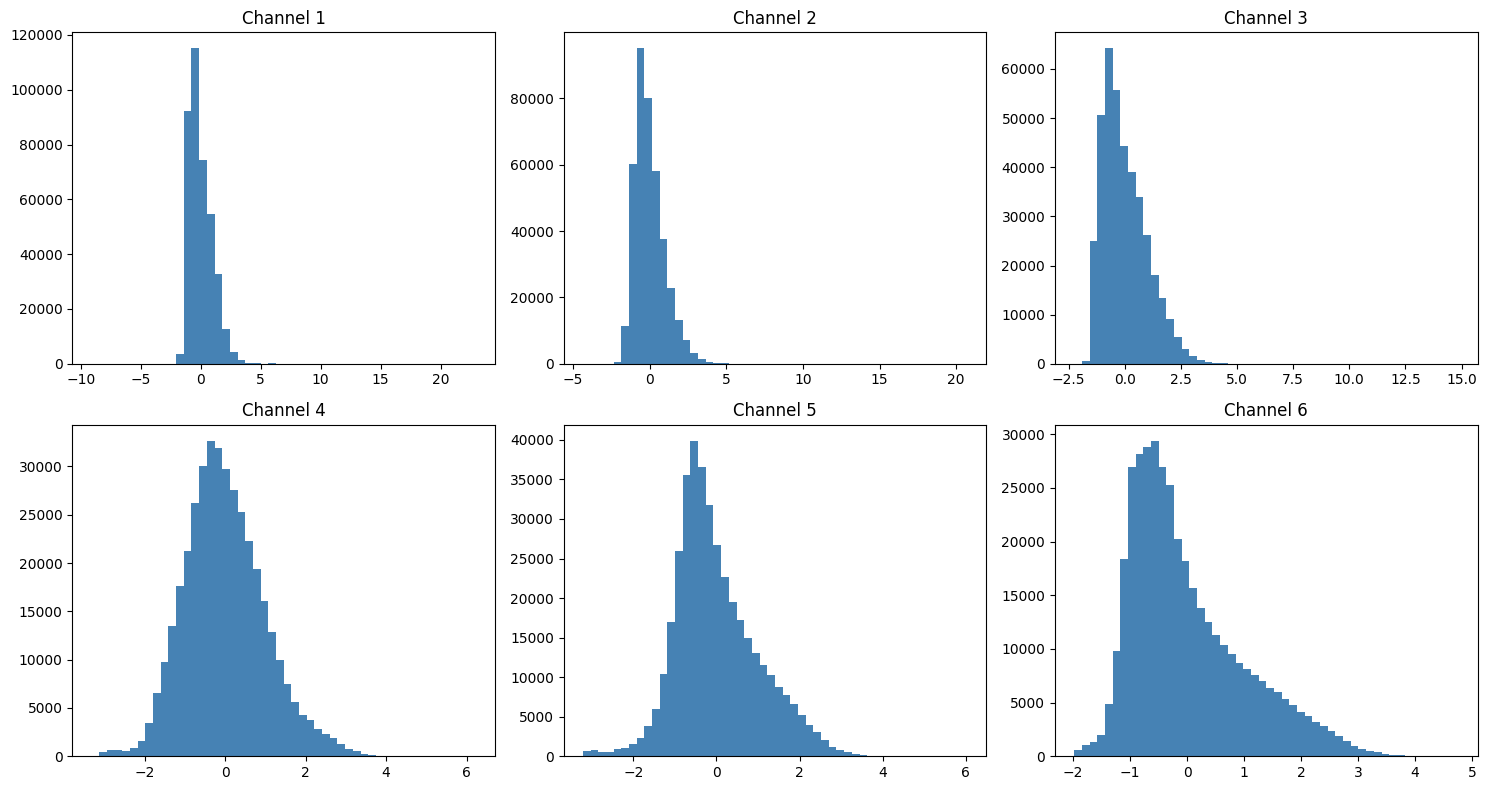



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         4432      31.66%
1         3632      25.94%
2         5936      42.40%

Total samples: 14000


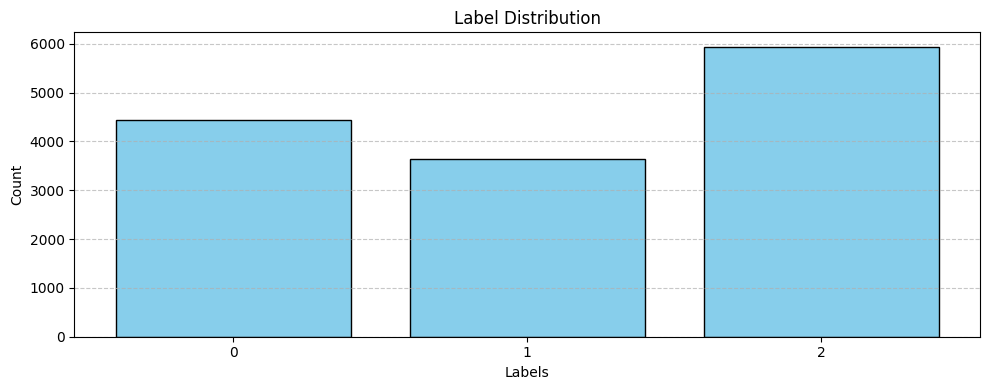


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


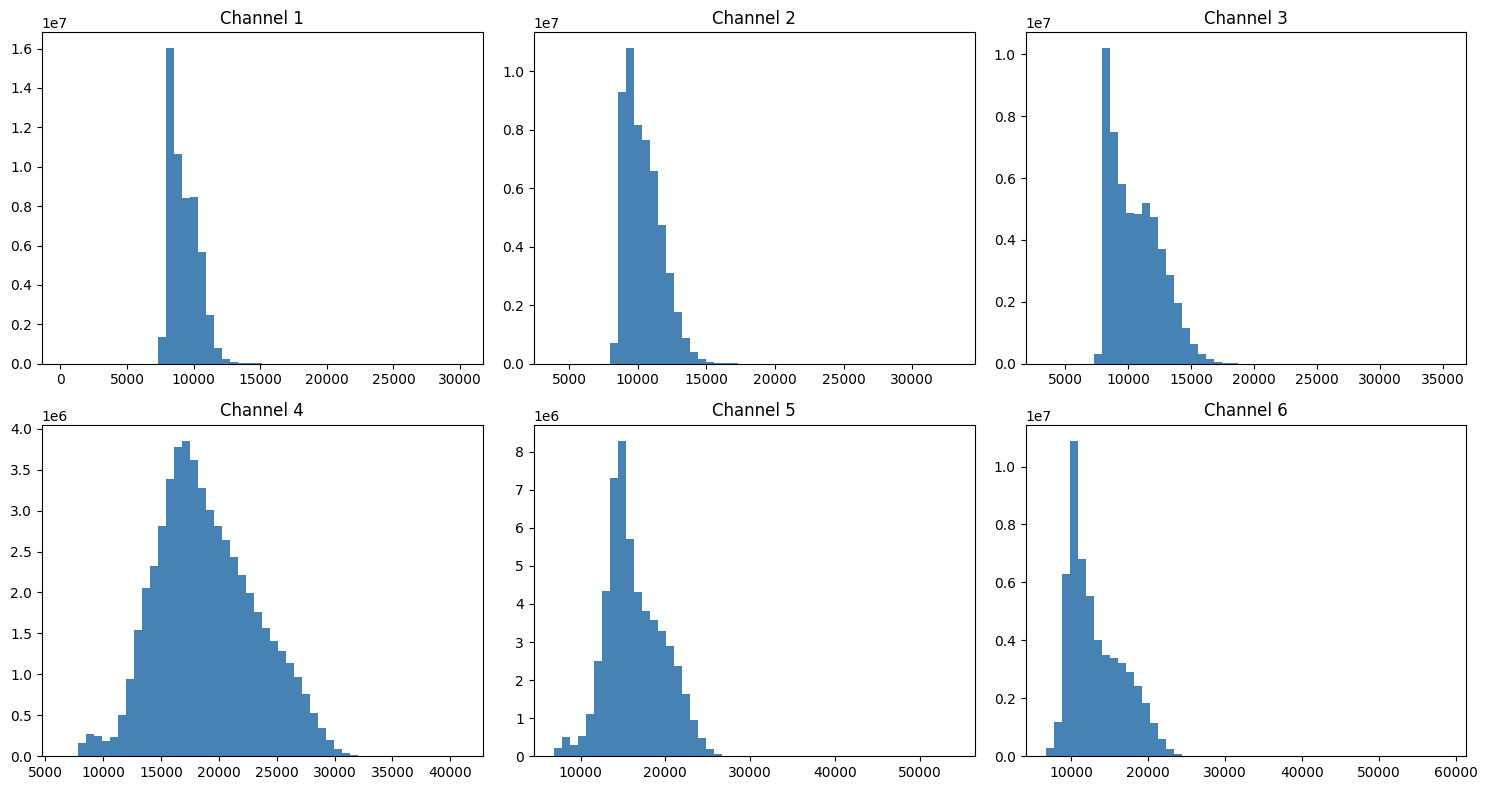

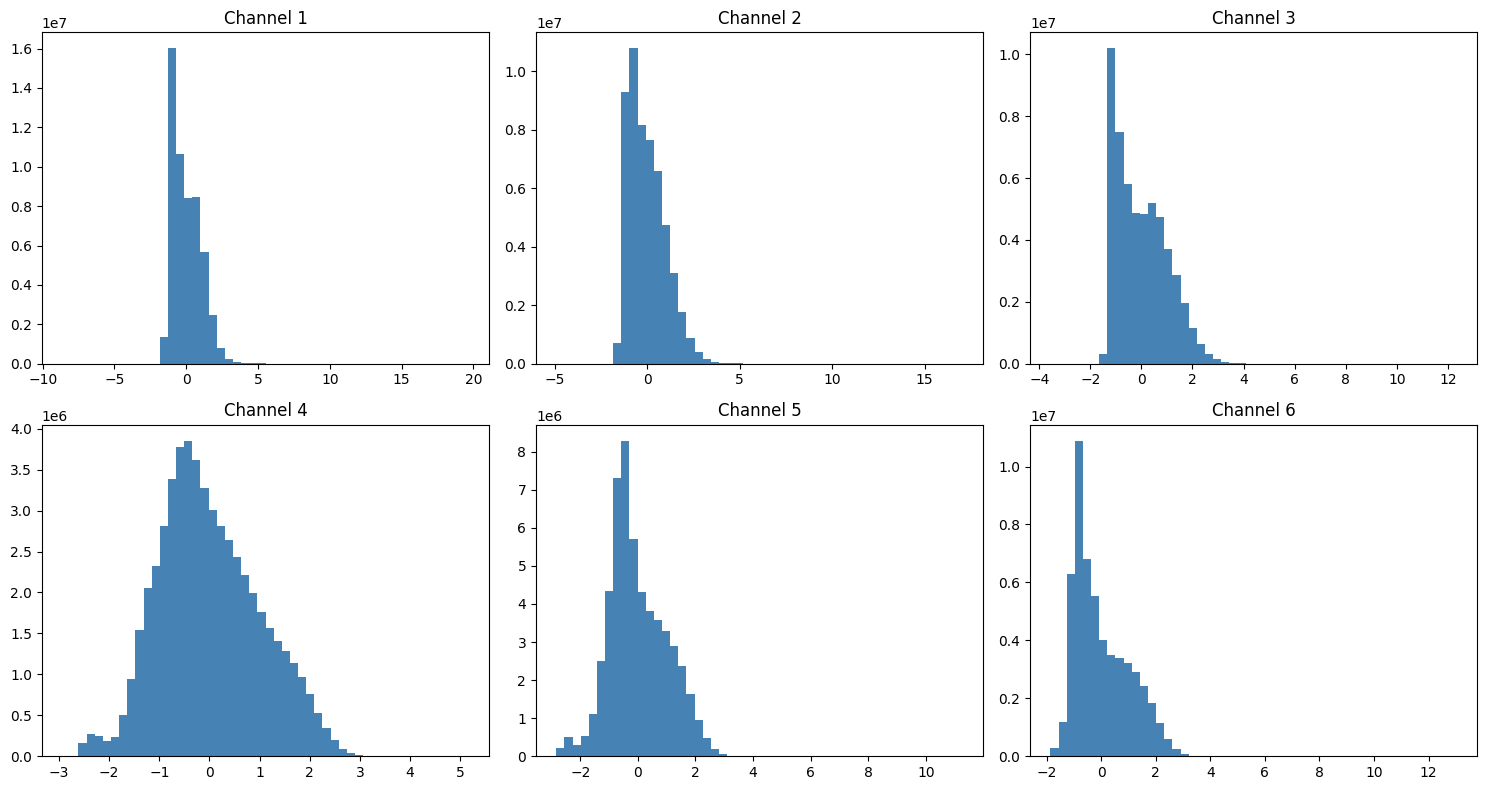



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


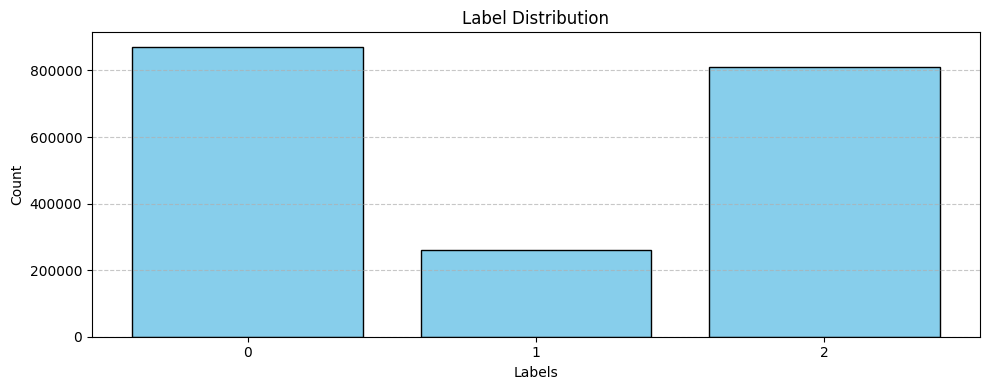

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([1.0529, 1.2849, 0.7862], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 43.05it/s]


Loss: 1.3513 + 1e-07 * 2697693.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.78it/s]


Epoch [1/50] Train Loss: 1.4197, Train Acc: 0.5061 | Val Loss: 0.7852, Val Acc: 0.8009, F1: 0.8071, Kappa: 0.6746


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.9598 + 1e-07 * 2517821.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.04it/s]


Epoch [2/50] Train Loss: 1.1807, Train Acc: 0.5414 | Val Loss: 0.7503, Val Acc: 0.8286, F1: 0.8348, Kappa: 0.7196


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.8457 + 1e-07 * 2341125.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.34it/s]


Epoch [3/50] Train Loss: 1.1084, Train Acc: 0.5741 | Val Loss: 0.6909, Val Acc: 0.8401, F1: 0.8462, Kappa: 0.7381


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 43.12it/s]


Loss: 0.8472 + 1e-07 * 2182671.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.61it/s]


Epoch [4/50] Train Loss: 1.0702, Train Acc: 0.5838 | Val Loss: 0.6566, Val Acc: 0.8376, F1: 0.8417, Kappa: 0.7349


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.8057 + 1e-07 * 2037991.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.74it/s]


Epoch [5/50] Train Loss: 1.0357, Train Acc: 0.5934 | Val Loss: 0.6203, Val Acc: 0.8534, F1: 0.8559, Kappa: 0.7602


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.99it/s]


Loss: 0.8852 + 1e-07 * 1909955.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.59it/s]


Epoch [6/50] Train Loss: 1.0123, Train Acc: 0.5975 | Val Loss: 0.6312, Val Acc: 0.8370, F1: 0.8448, Kappa: 0.7323


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.6568 + 1e-07 * 1793164.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.23it/s]


Epoch [7/50] Train Loss: 0.9863, Train Acc: 0.6011 | Val Loss: 0.5720, Val Acc: 0.8550, F1: 0.8583, Kappa: 0.7628


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.7504 + 1e-07 * 1693086.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.35it/s]


Epoch [8/50] Train Loss: 0.9716, Train Acc: 0.6050 | Val Loss: 0.5506, Val Acc: 0.8651, F1: 0.8687, Kappa: 0.7789


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.7493 + 1e-07 * 1601711.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 131.00it/s]


Epoch [9/50] Train Loss: 0.9529, Train Acc: 0.6133 | Val Loss: 0.5267, Val Acc: 0.8610, F1: 0.8654, Kappa: 0.7726


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.8422 + 1e-07 * 1522292.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.02it/s]


Epoch [10/50] Train Loss: 0.9428, Train Acc: 0.6152 | Val Loss: 0.5200, Val Acc: 0.8696, F1: 0.8740, Kappa: 0.7861


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 43.11it/s]


Loss: 0.7348 + 1e-07 * 1449416.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.60it/s]


Epoch [11/50] Train Loss: 0.9234, Train Acc: 0.6214 | Val Loss: 0.5065, Val Acc: 0.8730, F1: 0.8770, Kappa: 0.7922


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 43.17it/s]


Loss: 0.7181 + 1e-07 * 1383857.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.43it/s]


Epoch [12/50] Train Loss: 0.9033, Train Acc: 0.6199 | Val Loss: 0.4811, Val Acc: 0.8779, F1: 0.8810, Kappa: 0.7998


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.8271 + 1e-07 * 1325787.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.00it/s]


Epoch [13/50] Train Loss: 0.9073, Train Acc: 0.6163 | Val Loss: 0.4830, Val Acc: 0.8743, F1: 0.8771, Kappa: 0.7941


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 43.09it/s]


Loss: 0.6513 + 1e-07 * 1273095.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.66it/s]


Epoch [14/50] Train Loss: 0.8883, Train Acc: 0.6331 | Val Loss: 0.4609, Val Acc: 0.8796, F1: 0.8816, Kappa: 0.8030


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.8114 + 1e-07 * 1226954.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.45it/s]


Epoch [15/50] Train Loss: 0.8880, Train Acc: 0.6298 | Val Loss: 0.4515, Val Acc: 0.8768, F1: 0.8799, Kappa: 0.7983


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.7140 + 1e-07 * 1184752.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.80it/s]


Epoch [16/50] Train Loss: 0.8725, Train Acc: 0.6316 | Val Loss: 0.4496, Val Acc: 0.8768, F1: 0.8808, Kappa: 0.7980


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.6709 + 1e-07 * 1146967.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.95it/s]


Epoch [17/50] Train Loss: 0.8672, Train Acc: 0.6331 | Val Loss: 0.4622, Val Acc: 0.8699, F1: 0.8741, Kappa: 0.7870


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.7110 + 1e-07 * 1111246.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.21it/s]


Epoch [18/50] Train Loss: 0.8640, Train Acc: 0.6261 | Val Loss: 0.4393, Val Acc: 0.8839, F1: 0.8862, Kappa: 0.8098


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.94it/s]


Loss: 0.6299 + 1e-07 * 1078866.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.40it/s]


Epoch [19/50] Train Loss: 0.8515, Train Acc: 0.6354 | Val Loss: 0.4427, Val Acc: 0.8838, F1: 0.8871, Kappa: 0.8084


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.8329 + 1e-07 * 1049029.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.51it/s]


Epoch [20/50] Train Loss: 0.8478, Train Acc: 0.6387 | Val Loss: 0.4453, Val Acc: 0.8700, F1: 0.8722, Kappa: 0.7856


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.7910 + 1e-07 * 1022041.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.19it/s]


Epoch [21/50] Train Loss: 0.8451, Train Acc: 0.6394 | Val Loss: 0.4571, Val Acc: 0.8685, F1: 0.8750, Kappa: 0.7835


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.94it/s]


Loss: 0.7110 + 1e-07 * 996025.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 131.74it/s]


Epoch [22/50] Train Loss: 0.8345, Train Acc: 0.6406 | Val Loss: 0.4291, Val Acc: 0.8781, F1: 0.8832, Kappa: 0.7997


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.6904 + 1e-07 * 973444.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.11it/s]


Epoch [23/50] Train Loss: 0.8299, Train Acc: 0.6424 | Val Loss: 0.4347, Val Acc: 0.8716, F1: 0.8762, Kappa: 0.7895


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.5978 + 1e-07 * 952827.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.88it/s]


Epoch [24/50] Train Loss: 0.8295, Train Acc: 0.6456 | Val Loss: 0.4023, Val Acc: 0.8853, F1: 0.8888, Kappa: 0.8118


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 0.6431 + 1e-07 * 933237.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.65it/s]


Epoch [25/50] Train Loss: 0.8182, Train Acc: 0.6474 | Val Loss: 0.4125, Val Acc: 0.8817, F1: 0.8847, Kappa: 0.8057


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.75it/s]


Loss: 0.8844 + 1e-07 * 916183.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.98it/s]


Epoch [26/50] Train Loss: 0.8189, Train Acc: 0.6406 | Val Loss: 0.4083, Val Acc: 0.8798, F1: 0.8833, Kappa: 0.8030


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 43.11it/s]


Loss: 0.7492 + 1e-07 * 898800.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.22it/s]


Epoch [27/50] Train Loss: 0.8185, Train Acc: 0.6427 | Val Loss: 0.4098, Val Acc: 0.8803, F1: 0.8863, Kappa: 0.8031


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 43.09it/s]


Loss: 0.7220 + 1e-07 * 884245.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.22it/s]


Epoch [28/50] Train Loss: 0.8141, Train Acc: 0.6429 | Val Loss: 0.4133, Val Acc: 0.8840, F1: 0.8884, Kappa: 0.8092


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.7999 + 1e-07 * 870111.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.14it/s]


Epoch [29/50] Train Loss: 0.8108, Train Acc: 0.6508 | Val Loss: 0.3967, Val Acc: 0.8917, F1: 0.8946, Kappa: 0.8212


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.99it/s]


Loss: 0.5520 + 1e-07 * 857644.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.63it/s]


Epoch [30/50] Train Loss: 0.8042, Train Acc: 0.6509 | Val Loss: 0.4175, Val Acc: 0.8739, F1: 0.8780, Kappa: 0.7931


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.6246 + 1e-07 * 846509.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.17it/s]


Epoch [31/50] Train Loss: 0.8107, Train Acc: 0.6461 | Val Loss: 0.4027, Val Acc: 0.8796, F1: 0.8811, Kappa: 0.8025


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.6196 + 1e-07 * 835289.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.89it/s]


Epoch [32/50] Train Loss: 0.8029, Train Acc: 0.6514 | Val Loss: 0.3950, Val Acc: 0.8800, F1: 0.8847, Kappa: 0.8031


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.7133 + 1e-07 * 825166.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.58it/s]


Epoch [33/50] Train Loss: 0.7980, Train Acc: 0.6520 | Val Loss: 0.3834, Val Acc: 0.8863, F1: 0.8910, Kappa: 0.8129


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.5910 + 1e-07 * 816161.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.97it/s]


Epoch [34/50] Train Loss: 0.7973, Train Acc: 0.6551 | Val Loss: 0.3923, Val Acc: 0.8840, F1: 0.8871, Kappa: 0.8096


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 43.01it/s]


Loss: 0.7514 + 1e-07 * 805980.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 129.69it/s]


Epoch [35/50] Train Loss: 0.7943, Train Acc: 0.6513 | Val Loss: 0.3935, Val Acc: 0.8819, F1: 0.8856, Kappa: 0.8062


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.94it/s]


Loss: 0.9703 + 1e-07 * 798015.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.47it/s]


Epoch [36/50] Train Loss: 0.7931, Train Acc: 0.6518 | Val Loss: 0.3998, Val Acc: 0.8786, F1: 0.8843, Kappa: 0.8004


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.7907 + 1e-07 * 790089.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.08it/s]


Epoch [37/50] Train Loss: 0.7911, Train Acc: 0.6559 | Val Loss: 0.3730, Val Acc: 0.8891, F1: 0.8922, Kappa: 0.8174


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 43.05it/s]


Loss: 0.6694 + 1e-07 * 783201.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.10it/s]


Epoch [38/50] Train Loss: 0.7858, Train Acc: 0.6556 | Val Loss: 0.4198, Val Acc: 0.8683, F1: 0.8738, Kappa: 0.7835


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.5318 + 1e-07 * 777080.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.94it/s]


Epoch [39/50] Train Loss: 0.7863, Train Acc: 0.6608 | Val Loss: 0.3758, Val Acc: 0.8863, F1: 0.8912, Kappa: 0.8130


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.8461 + 1e-07 * 771979.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.08it/s]


Epoch [40/50] Train Loss: 0.7898, Train Acc: 0.6549 | Val Loss: 0.3916, Val Acc: 0.8763, F1: 0.8783, Kappa: 0.7975


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.7433 + 1e-07 * 764090.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.08it/s]


Epoch [41/50] Train Loss: 0.7753, Train Acc: 0.6595 | Val Loss: 0.3765, Val Acc: 0.8863, F1: 0.8909, Kappa: 0.8131


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.9781 + 1e-07 * 757606.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.75it/s]


Epoch [42/50] Train Loss: 0.7829, Train Acc: 0.6575 | Val Loss: 0.3690, Val Acc: 0.8896, F1: 0.8930, Kappa: 0.8185


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.7636 + 1e-07 * 751665.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.06it/s]


Epoch [43/50] Train Loss: 0.7806, Train Acc: 0.6536 | Val Loss: 0.4652, Val Acc: 0.8323, F1: 0.8469, Kappa: 0.7237


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.8143 + 1e-07 * 748395.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.20it/s]


Epoch [44/50] Train Loss: 0.7776, Train Acc: 0.6586 | Val Loss: 0.3899, Val Acc: 0.8789, F1: 0.8835, Kappa: 0.8008


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.6197 + 1e-07 * 743414.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.07it/s]


Epoch [45/50] Train Loss: 0.7679, Train Acc: 0.6653 | Val Loss: 0.3820, Val Acc: 0.8780, F1: 0.8827, Kappa: 0.7994


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 0.7313 + 1e-07 * 738513.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.86it/s]


Epoch [46/50] Train Loss: 0.7659, Train Acc: 0.6583 | Val Loss: 0.3735, Val Acc: 0.8795, F1: 0.8845, Kappa: 0.8017


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.67it/s]


Loss: 0.5053 + 1e-07 * 735127.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.86it/s]


Epoch [47/50] Train Loss: 0.7701, Train Acc: 0.6616 | Val Loss: 0.3937, Val Acc: 0.8699, F1: 0.8771, Kappa: 0.7859


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.7014 + 1e-07 * 731246.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 130.76it/s]


Epoch [48/50] Train Loss: 0.7710, Train Acc: 0.6626 | Val Loss: 0.4618, Val Acc: 0.8379, F1: 0.8492, Kappa: 0.7317


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.5563 + 1e-07 * 726017.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.79it/s]


Epoch [49/50] Train Loss: 0.7641, Train Acc: 0.6672 | Val Loss: 0.3742, Val Acc: 0.8848, F1: 0.8884, Kappa: 0.8109


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.7184 + 1e-07 * 721446.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.91it/s]


Epoch [50/50] Train Loss: 0.7586, Train Acc: 0.6660 | Val Loss: 0.3842, Val Acc: 0.8822, F1: 0.8876, Kappa: 0.8063


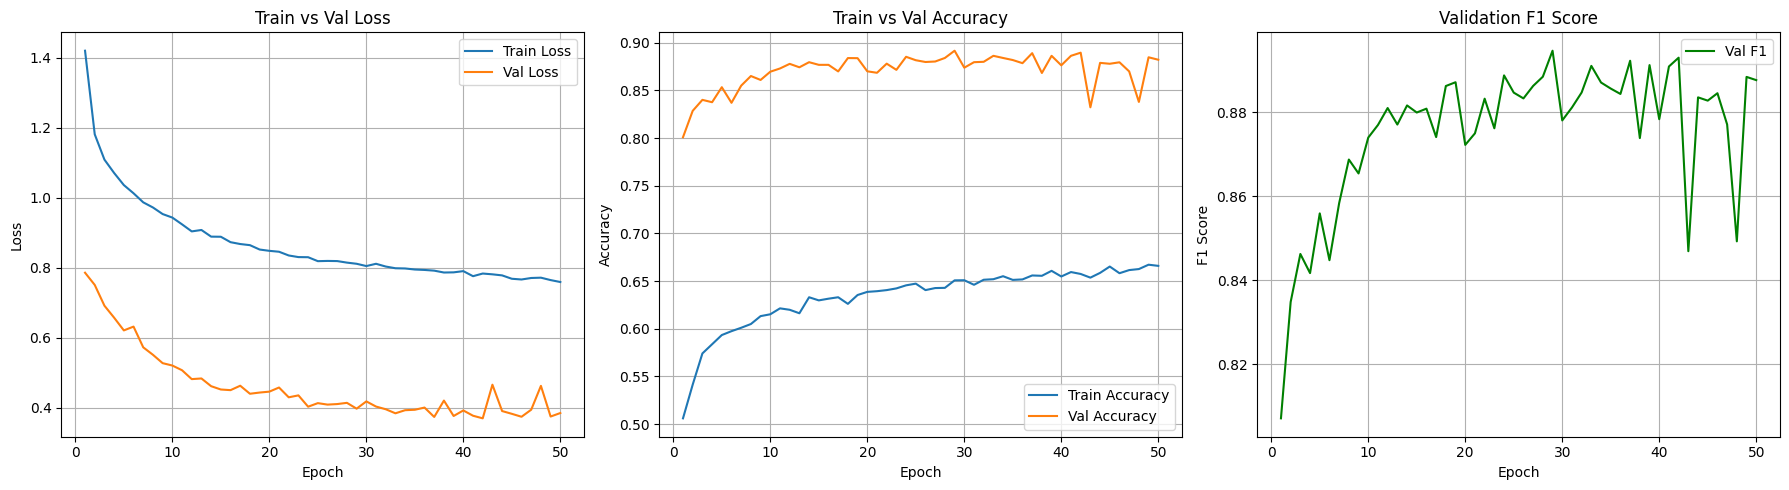


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:40<00:00, 137.23it/s]



====== Test Results ======
Overall Loss: 0.3901
Overall Accuracy: 0.8786
Cohen's Kappa: 0.8000
Per Class F1: [0.87688076 0.90541056 0.87155991]
Macro (Avg) F1: 0.8846


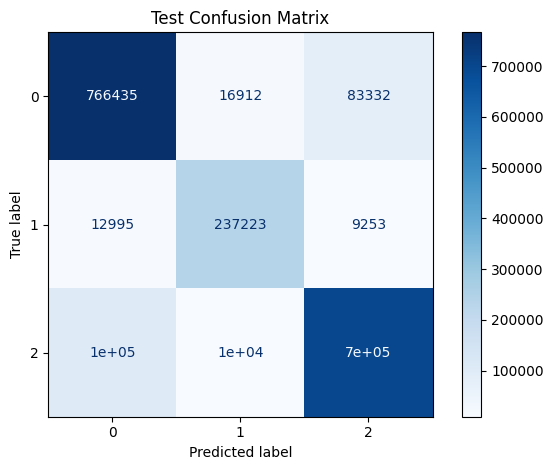

History Dumped in file /kaggle/working/deterministic_CNN_data_entropy_history.json


====== Loading Data /kaggle/input/data-al/deterministic_CNN_data_entropy_diversity.npz ======
Train Data:  (14000, 28, 6) (14000,)


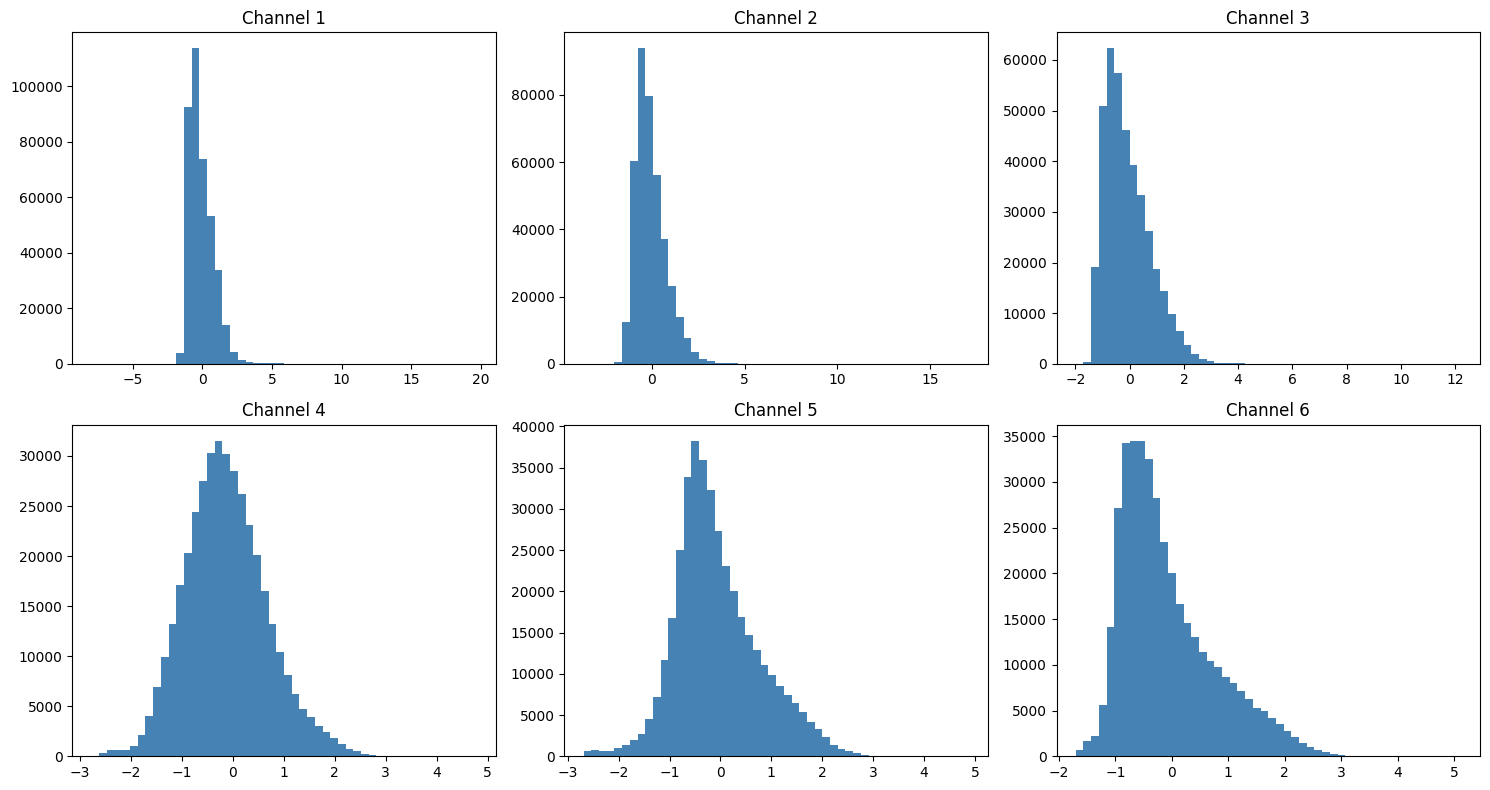

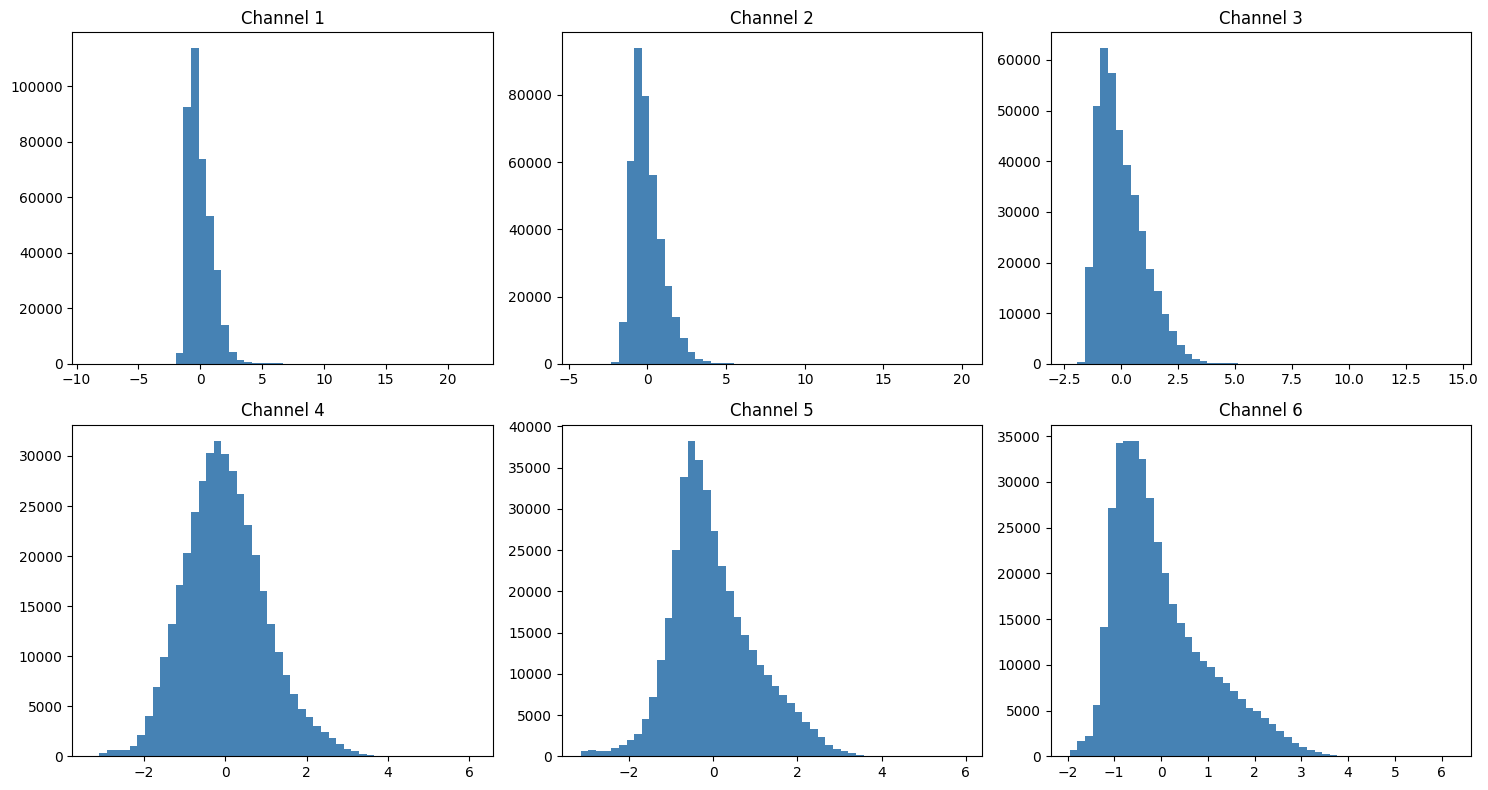



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         5459      38.99%
1         1899      13.56%
2         6642      47.44%

Total samples: 14000


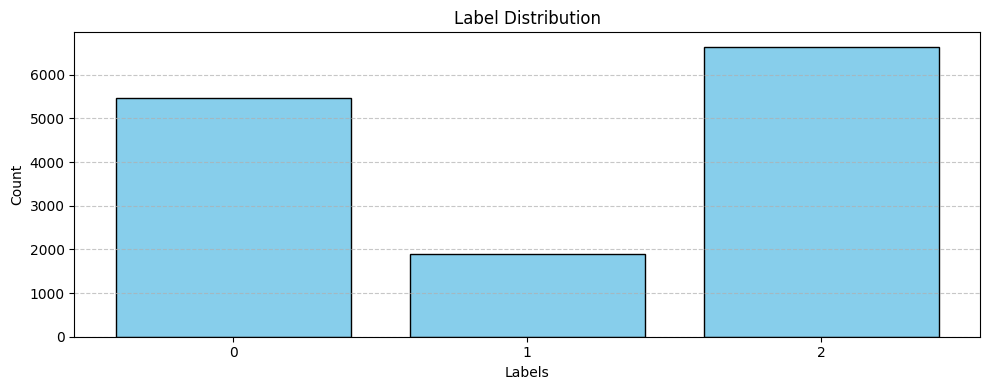


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


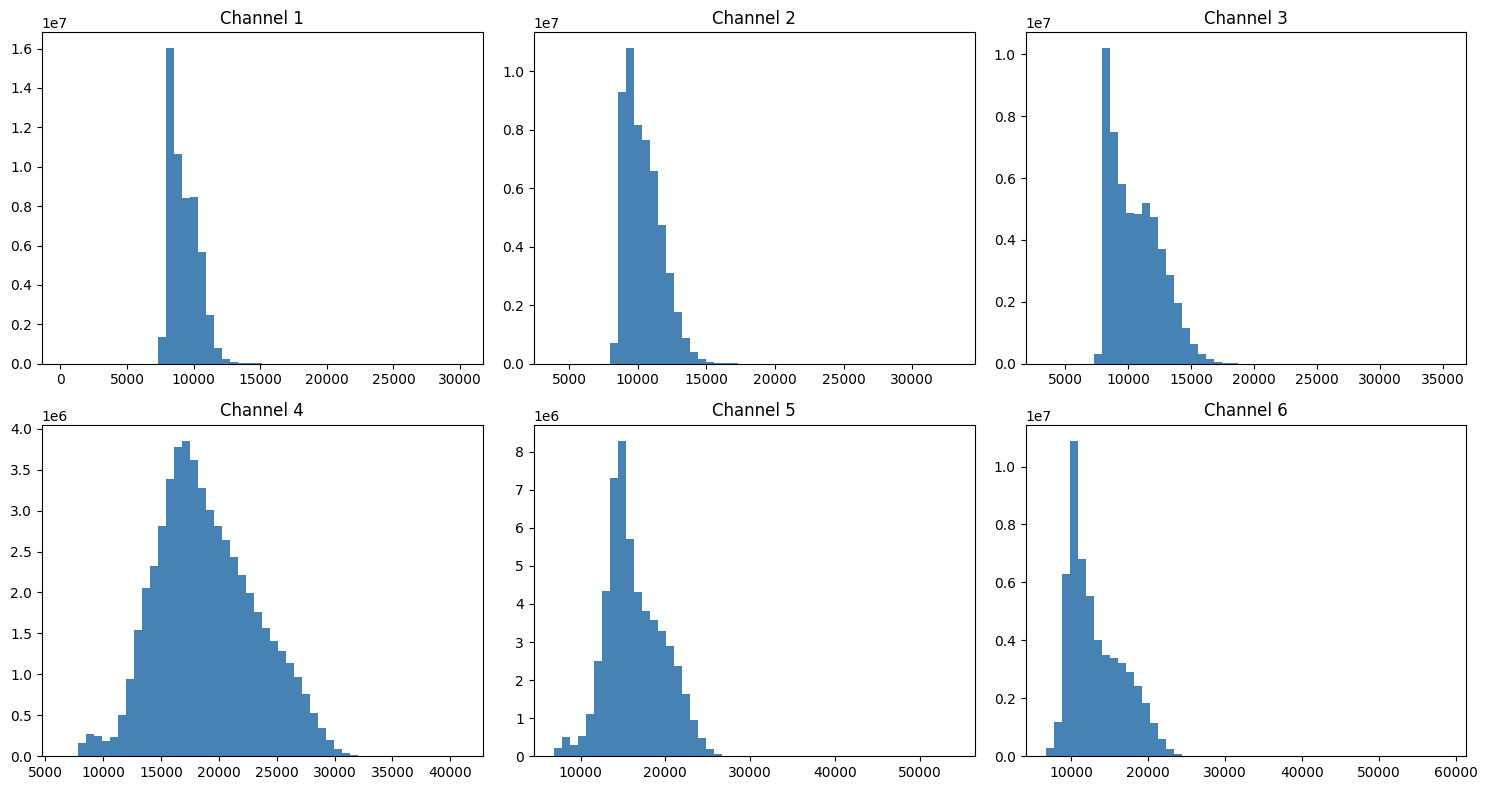

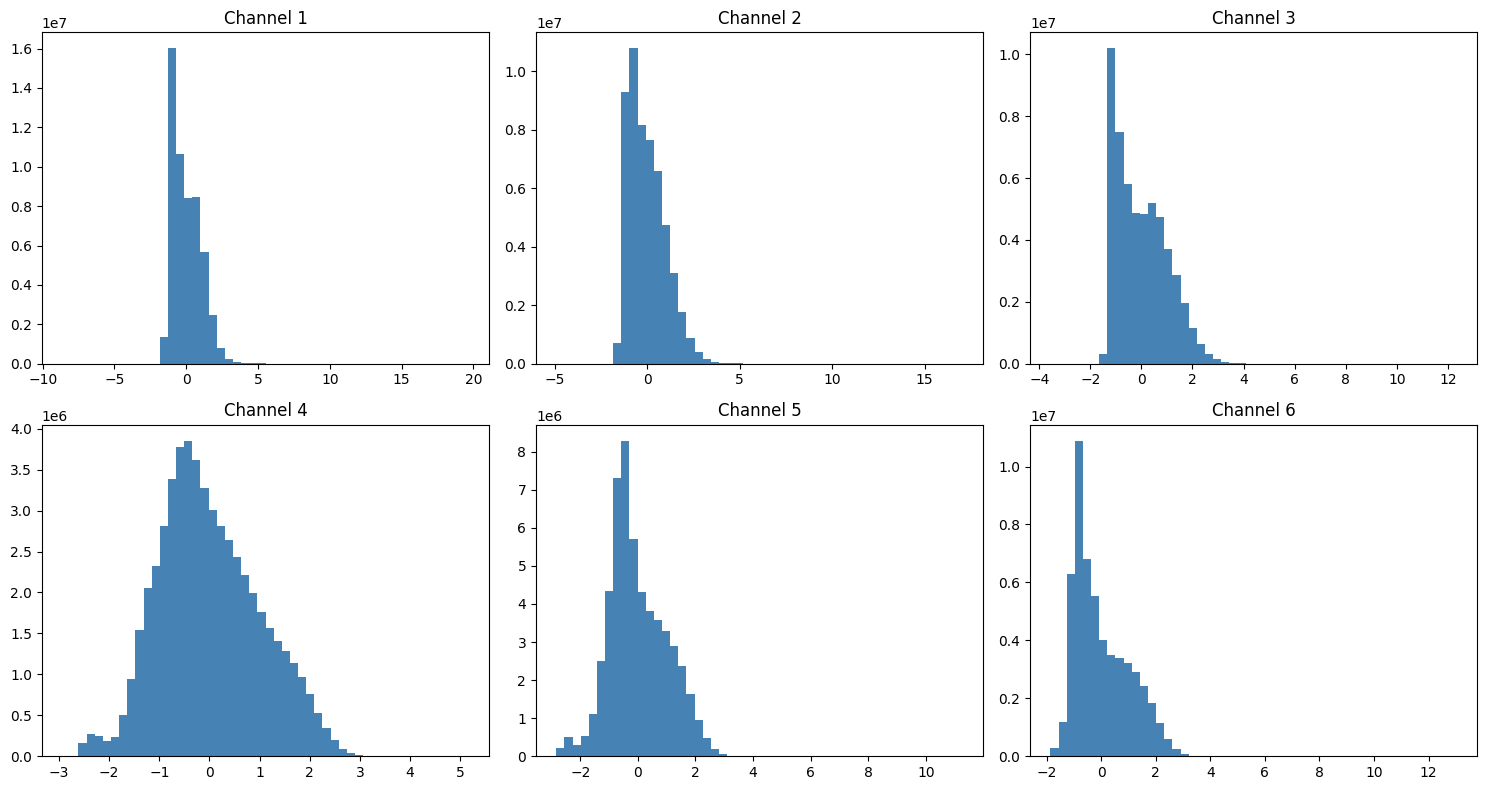



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


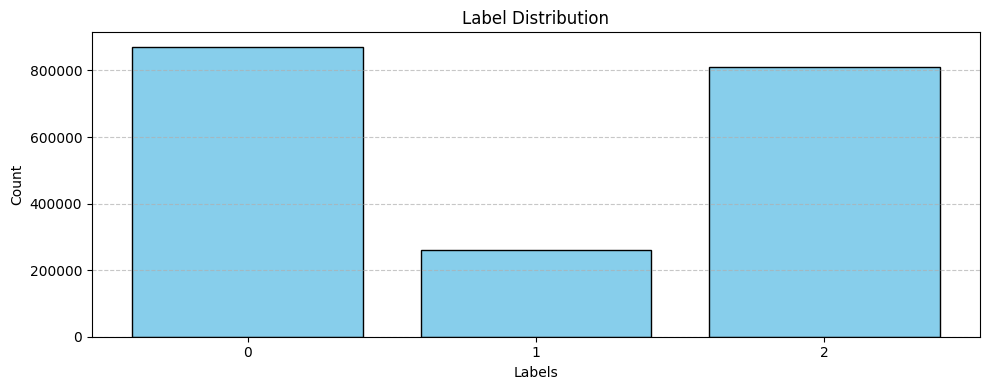

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.8549, 2.4574, 0.7026], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 1.0917 + 1e-07 * 2711348.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.82it/s]


Epoch [1/50] Train Loss: 1.4820, Train Acc: 0.4841 | Val Loss: 0.7939, Val Acc: 0.7675, F1: 0.7790, Kappa: 0.6227


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 43.05it/s]


Loss: 1.1969 + 1e-07 * 2540712.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.23it/s]


Epoch [2/50] Train Loss: 1.2165, Train Acc: 0.5300 | Val Loss: 0.7190, Val Acc: 0.8230, F1: 0.8229, Kappa: 0.7135


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.8301 + 1e-07 * 2374276.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.61it/s]


Epoch [3/50] Train Loss: 1.1523, Train Acc: 0.5379 | Val Loss: 0.6824, Val Acc: 0.8331, F1: 0.8333, Kappa: 0.7296


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.8647 + 1e-07 * 2222798.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.63it/s]


Epoch [4/50] Train Loss: 1.1233, Train Acc: 0.5478 | Val Loss: 0.6620, Val Acc: 0.8404, F1: 0.8405, Kappa: 0.7414


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.8563 + 1e-07 * 2081955.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.27it/s]


Epoch [5/50] Train Loss: 1.0874, Train Acc: 0.5524 | Val Loss: 0.6013, Val Acc: 0.8501, F1: 0.8499, Kappa: 0.7567


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.8214 + 1e-07 * 1959609.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.13it/s]


Epoch [6/50] Train Loss: 1.0543, Train Acc: 0.5622 | Val Loss: 0.5821, Val Acc: 0.8547, F1: 0.8543, Kappa: 0.7639


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 43.13it/s]


Loss: 0.7543 + 1e-07 * 1848144.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.00it/s]


Epoch [7/50] Train Loss: 1.0385, Train Acc: 0.5666 | Val Loss: 0.5796, Val Acc: 0.8491, F1: 0.8475, Kappa: 0.7553


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.8146 + 1e-07 * 1747484.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.18it/s]


Epoch [8/50] Train Loss: 1.0154, Train Acc: 0.5664 | Val Loss: 0.5637, Val Acc: 0.8454, F1: 0.8408, Kappa: 0.7505


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.7366 + 1e-07 * 1658648.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.37it/s]


Epoch [9/50] Train Loss: 1.0021, Train Acc: 0.5709 | Val Loss: 0.5327, Val Acc: 0.8610, F1: 0.8585, Kappa: 0.7746


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.86it/s]


Loss: 0.7069 + 1e-07 * 1578765.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.65it/s]


Epoch [10/50] Train Loss: 0.9854, Train Acc: 0.5720 | Val Loss: 0.5095, Val Acc: 0.8590, F1: 0.8571, Kappa: 0.7711


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.8575 + 1e-07 * 1507600.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.47it/s]


Epoch [11/50] Train Loss: 0.9752, Train Acc: 0.5749 | Val Loss: 0.5151, Val Acc: 0.8663, F1: 0.8642, Kappa: 0.7827


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.87it/s]


Loss: 0.7472 + 1e-07 * 1444461.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.57it/s]


Epoch [12/50] Train Loss: 0.9579, Train Acc: 0.5849 | Val Loss: 0.4902, Val Acc: 0.8700, F1: 0.8676, Kappa: 0.7889


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 43.19it/s]


Loss: 0.8779 + 1e-07 * 1385925.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.69it/s]


Epoch [13/50] Train Loss: 0.9375, Train Acc: 0.5916 | Val Loss: 0.4962, Val Acc: 0.8644, F1: 0.8649, Kappa: 0.7788


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.78it/s]


Loss: 0.7344 + 1e-07 * 1333640.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.13it/s]


Epoch [14/50] Train Loss: 0.9352, Train Acc: 0.5916 | Val Loss: 0.4757, Val Acc: 0.8669, F1: 0.8647, Kappa: 0.7838


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.9459 + 1e-07 * 1289087.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.40it/s]


Epoch [15/50] Train Loss: 0.9277, Train Acc: 0.5985 | Val Loss: 0.4526, Val Acc: 0.8676, F1: 0.8633, Kappa: 0.7855


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.7276 + 1e-07 * 1245085.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.29it/s]


Epoch [16/50] Train Loss: 0.9155, Train Acc: 0.5972 | Val Loss: 0.4510, Val Acc: 0.8705, F1: 0.8700, Kappa: 0.7893


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.7527 + 1e-07 * 1205639.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.49it/s]


Epoch [17/50] Train Loss: 0.9067, Train Acc: 0.6036 | Val Loss: 0.4401, Val Acc: 0.8689, F1: 0.8648, Kappa: 0.7873


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 1.0058 + 1e-07 * 1169707.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.13it/s]


Epoch [18/50] Train Loss: 0.9082, Train Acc: 0.5935 | Val Loss: 0.4431, Val Acc: 0.8724, F1: 0.8706, Kappa: 0.7927


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.8810 + 1e-07 * 1138330.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.09it/s]


Epoch [19/50] Train Loss: 0.8944, Train Acc: 0.6009 | Val Loss: 0.4309, Val Acc: 0.8710, F1: 0.8687, Kappa: 0.7903


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 43.09it/s]


Loss: 0.7852 + 1e-07 * 1108314.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.23it/s]


Epoch [20/50] Train Loss: 0.8991, Train Acc: 0.6000 | Val Loss: 0.4230, Val Acc: 0.8727, F1: 0.8687, Kappa: 0.7936


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 43.13it/s]


Loss: 0.6471 + 1e-07 * 1080905.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.62it/s]


Epoch [21/50] Train Loss: 0.8817, Train Acc: 0.6072 | Val Loss: 0.4141, Val Acc: 0.8777, F1: 0.8753, Kappa: 0.8013


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.8826 + 1e-07 * 1056986.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.34it/s]


Epoch [22/50] Train Loss: 0.8852, Train Acc: 0.6023 | Val Loss: 0.4300, Val Acc: 0.8719, F1: 0.8722, Kappa: 0.7910


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.7424 + 1e-07 * 1032827.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.32it/s]


Epoch [23/50] Train Loss: 0.8766, Train Acc: 0.6046 | Val Loss: 0.4191, Val Acc: 0.8733, F1: 0.8712, Kappa: 0.7941


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.7756 + 1e-07 * 1011205.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.33it/s]


Epoch [24/50] Train Loss: 0.8675, Train Acc: 0.6117 | Val Loss: 0.4014, Val Acc: 0.8753, F1: 0.8736, Kappa: 0.7974


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 42.99it/s]


Loss: 0.8378 + 1e-07 * 992647.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.75it/s]


Epoch [25/50] Train Loss: 0.8683, Train Acc: 0.6043 | Val Loss: 0.4069, Val Acc: 0.8731, F1: 0.8709, Kappa: 0.7934


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.9391 + 1e-07 * 972121.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.61it/s]


Epoch [26/50] Train Loss: 0.8538, Train Acc: 0.6221 | Val Loss: 0.3973, Val Acc: 0.8758, F1: 0.8766, Kappa: 0.7976


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.7410 + 1e-07 * 956288.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.19it/s]


Epoch [27/50] Train Loss: 0.8613, Train Acc: 0.6176 | Val Loss: 0.4120, Val Acc: 0.8768, F1: 0.8766, Kappa: 0.7993


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 43.00it/s]


Loss: 0.8798 + 1e-07 * 939848.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.10it/s]


Epoch [28/50] Train Loss: 0.8515, Train Acc: 0.6127 | Val Loss: 0.4000, Val Acc: 0.8762, F1: 0.8754, Kappa: 0.7985


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.8671 + 1e-07 * 925549.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.98it/s]


Epoch [29/50] Train Loss: 0.8398, Train Acc: 0.6173 | Val Loss: 0.3913, Val Acc: 0.8833, F1: 0.8810, Kappa: 0.8101


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.7542 + 1e-07 * 912660.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.11it/s]


Epoch [30/50] Train Loss: 0.8527, Train Acc: 0.6189 | Val Loss: 0.3819, Val Acc: 0.8834, F1: 0.8832, Kappa: 0.8098


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.8078 + 1e-07 * 898715.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.67it/s]


Epoch [31/50] Train Loss: 0.8377, Train Acc: 0.6259 | Val Loss: 0.4029, Val Acc: 0.8687, F1: 0.8694, Kappa: 0.7861


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.5564 + 1e-07 * 886698.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.53it/s]


Epoch [32/50] Train Loss: 0.8294, Train Acc: 0.6271 | Val Loss: 0.3869, Val Acc: 0.8735, F1: 0.8706, Kappa: 0.7945


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.6827 + 1e-07 * 875659.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.74it/s]


Epoch [33/50] Train Loss: 0.8337, Train Acc: 0.6210 | Val Loss: 0.3844, Val Acc: 0.8739, F1: 0.8721, Kappa: 0.7952


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.7029 + 1e-07 * 865760.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.93it/s]


Epoch [34/50] Train Loss: 0.8294, Train Acc: 0.6249 | Val Loss: 0.3788, Val Acc: 0.8793, F1: 0.8774, Kappa: 0.8036


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.6728 + 1e-07 * 855620.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.61it/s]


Epoch [35/50] Train Loss: 0.8279, Train Acc: 0.6295 | Val Loss: 0.3801, Val Acc: 0.8812, F1: 0.8813, Kappa: 0.8059


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.7787 + 1e-07 * 847182.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.63it/s]


Epoch [36/50] Train Loss: 0.8270, Train Acc: 0.6185 | Val Loss: 0.3864, Val Acc: 0.8753, F1: 0.8749, Kappa: 0.7969


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.7172 + 1e-07 * 839572.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.02it/s]


Epoch [37/50] Train Loss: 0.8236, Train Acc: 0.6212 | Val Loss: 0.3693, Val Acc: 0.8800, F1: 0.8784, Kappa: 0.8041


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.6713 + 1e-07 * 830814.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.13it/s]


Epoch [38/50] Train Loss: 0.8283, Train Acc: 0.6251 | Val Loss: 0.3939, Val Acc: 0.8724, F1: 0.8698, Kappa: 0.7928


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 43.09it/s]


Loss: 0.7411 + 1e-07 * 823907.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.45it/s]


Epoch [39/50] Train Loss: 0.8244, Train Acc: 0.6264 | Val Loss: 0.3977, Val Acc: 0.8666, F1: 0.8661, Kappa: 0.7829


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.6501 + 1e-07 * 816665.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.10it/s]


Epoch [40/50] Train Loss: 0.8157, Train Acc: 0.6329 | Val Loss: 0.3963, Val Acc: 0.8683, F1: 0.8675, Kappa: 0.7864


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.6967 + 1e-07 * 811936.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.66it/s]


Epoch [41/50] Train Loss: 0.8147, Train Acc: 0.6323 | Val Loss: 0.3583, Val Acc: 0.8867, F1: 0.8867, Kappa: 0.8150


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 43.07it/s]


Loss: 0.6406 + 1e-07 * 806672.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.02it/s]


Epoch [42/50] Train Loss: 0.8160, Train Acc: 0.6344 | Val Loss: 0.3948, Val Acc: 0.8631, F1: 0.8602, Kappa: 0.7781


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.8138 + 1e-07 * 800413.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.19it/s]


Epoch [43/50] Train Loss: 0.8130, Train Acc: 0.6290 | Val Loss: 0.3706, Val Acc: 0.8792, F1: 0.8766, Kappa: 0.8036


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 43.01it/s]


Loss: 0.6293 + 1e-07 * 795004.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.76it/s]


Epoch [44/50] Train Loss: 0.8080, Train Acc: 0.6324 | Val Loss: 0.3695, Val Acc: 0.8769, F1: 0.8756, Kappa: 0.8001


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.9045 + 1e-07 * 790889.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.25it/s]


Epoch [45/50] Train Loss: 0.8109, Train Acc: 0.6364 | Val Loss: 0.3710, Val Acc: 0.8830, F1: 0.8823, Kappa: 0.8088


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.6304 + 1e-07 * 786491.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.64it/s]


Epoch [46/50] Train Loss: 0.8102, Train Acc: 0.6374 | Val Loss: 0.3918, Val Acc: 0.8763, F1: 0.8789, Kappa: 0.7978


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 43.11it/s]


Loss: 0.6583 + 1e-07 * 782259.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.26it/s]


Epoch [47/50] Train Loss: 0.8023, Train Acc: 0.6415 | Val Loss: 0.3736, Val Acc: 0.8759, F1: 0.8759, Kappa: 0.7978


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.9047 + 1e-07 * 776902.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.10it/s]


Epoch [48/50] Train Loss: 0.7986, Train Acc: 0.6379 | Val Loss: 0.3577, Val Acc: 0.8852, F1: 0.8870, Kappa: 0.8123


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.7617 + 1e-07 * 771834.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.89it/s]


Epoch [49/50] Train Loss: 0.7932, Train Acc: 0.6371 | Val Loss: 0.3603, Val Acc: 0.8842, F1: 0.8835, Kappa: 0.8111


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.6281 + 1e-07 * 767392.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 132.26it/s]


Epoch [50/50] Train Loss: 0.7915, Train Acc: 0.6389 | Val Loss: 0.3729, Val Acc: 0.8790, F1: 0.8782, Kappa: 0.8027


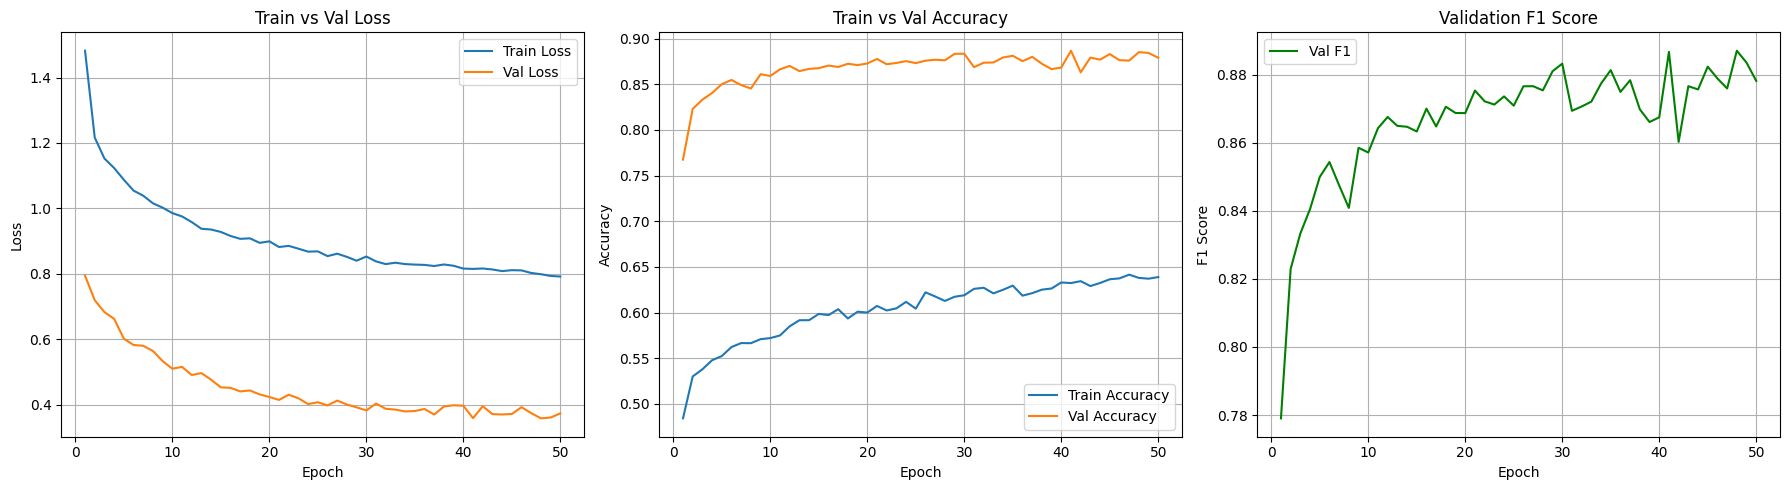


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:43<00:00, 135.47it/s]



====== Test Results ======
Overall Loss: 0.3714
Overall Accuracy: 0.8809
Cohen's Kappa: 0.8055
Per Class F1: [0.88304515 0.87777708 0.87963984]
Macro (Avg) F1: 0.8802


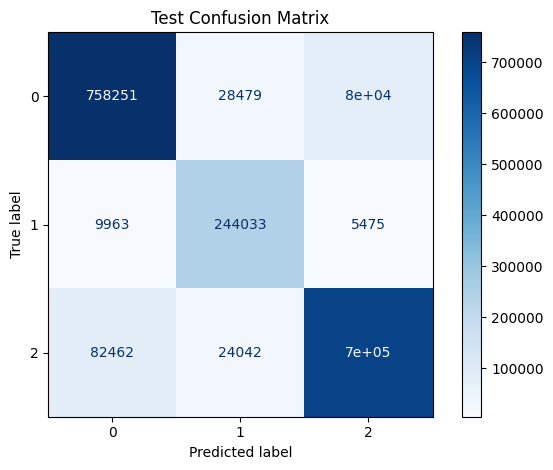

History Dumped in file /kaggle/working/deterministic_CNN_data_entropy_diversity_history.json


====== Loading Data /kaggle/input/data-al/deterministic_CNN_data_margin.npz ======
Train Data:  (14000, 28, 6) (14000,)


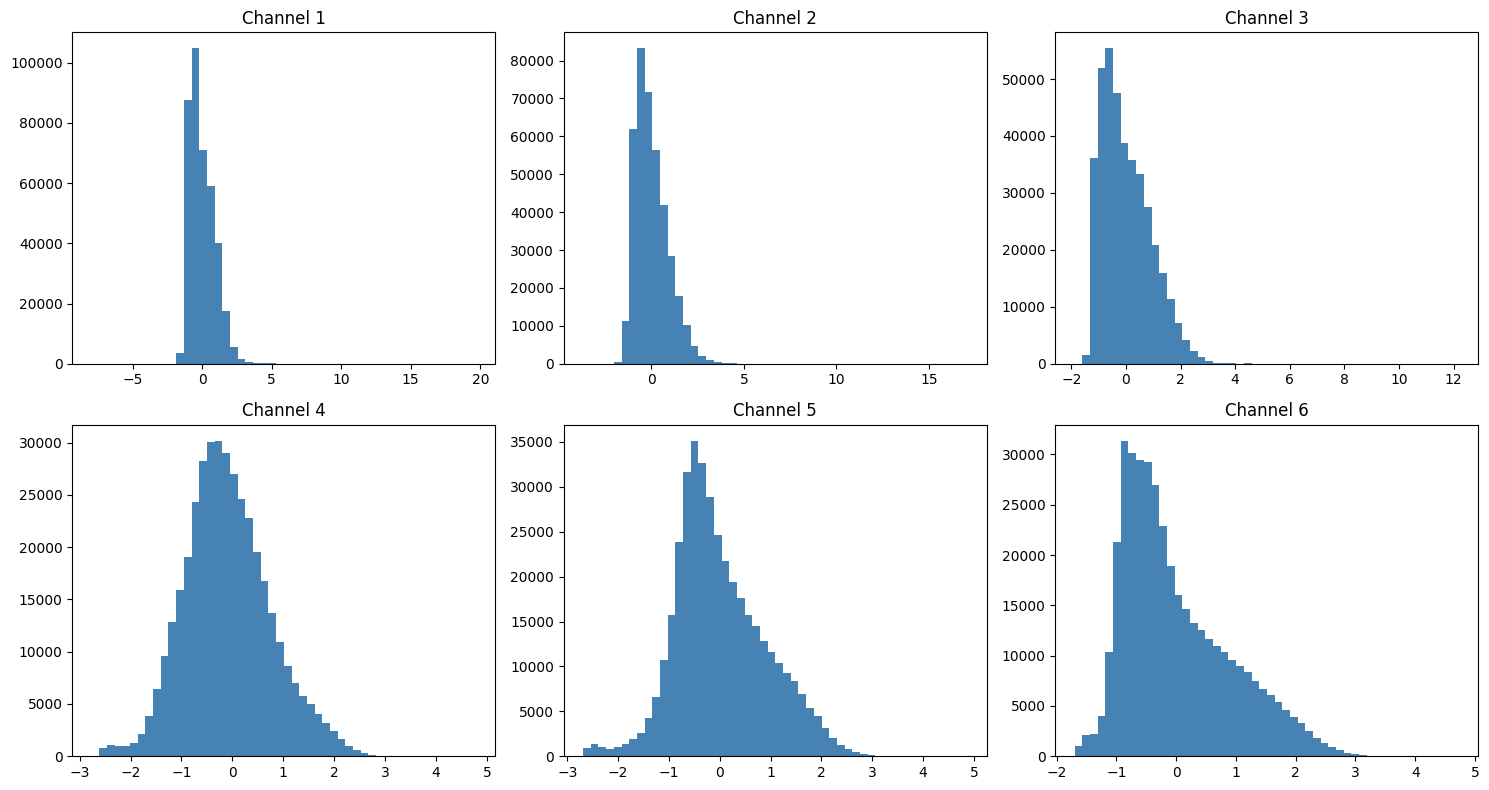

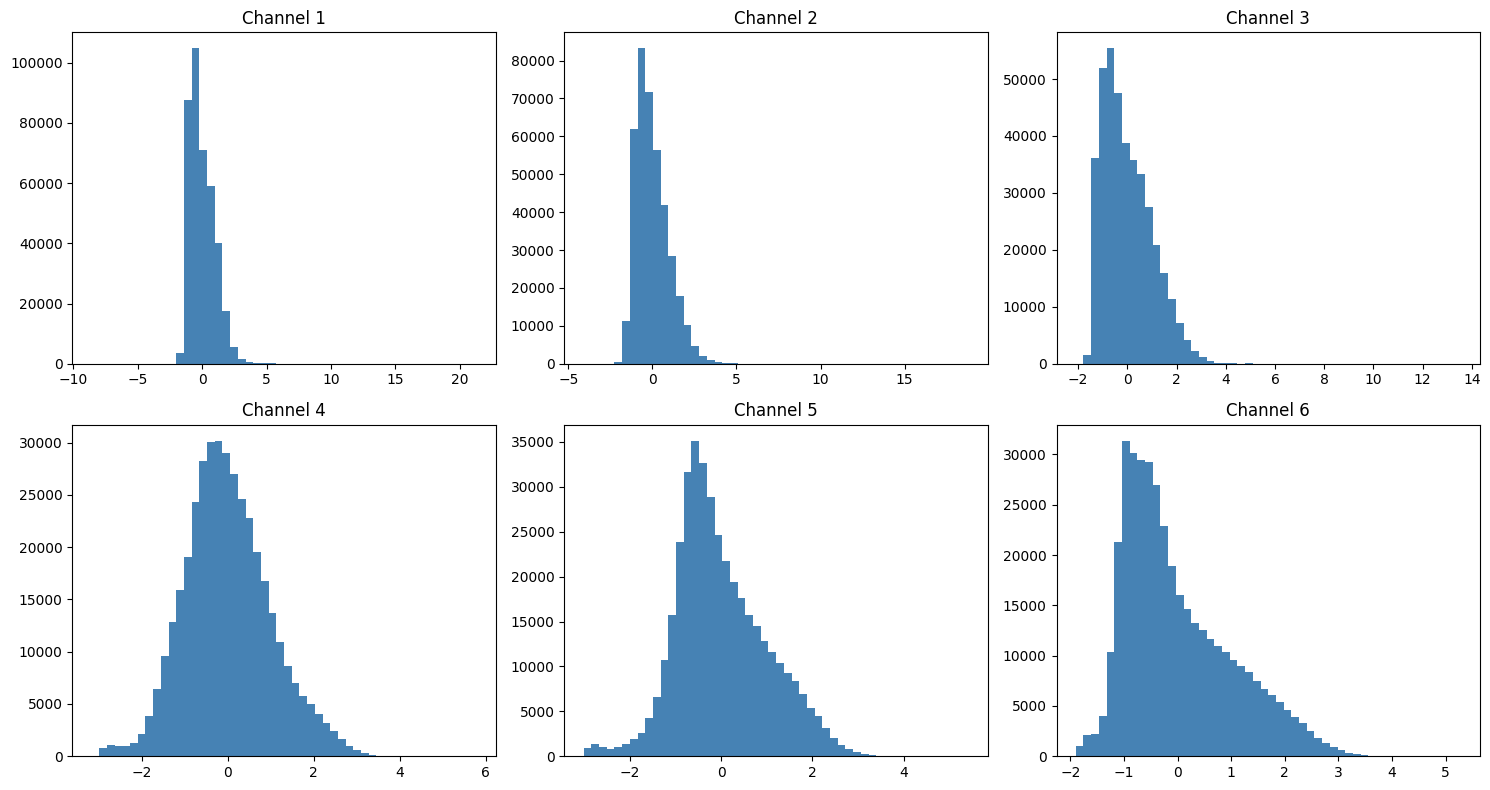



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6375      45.54%
1         1412      10.09%
2         6213      44.38%

Total samples: 14000


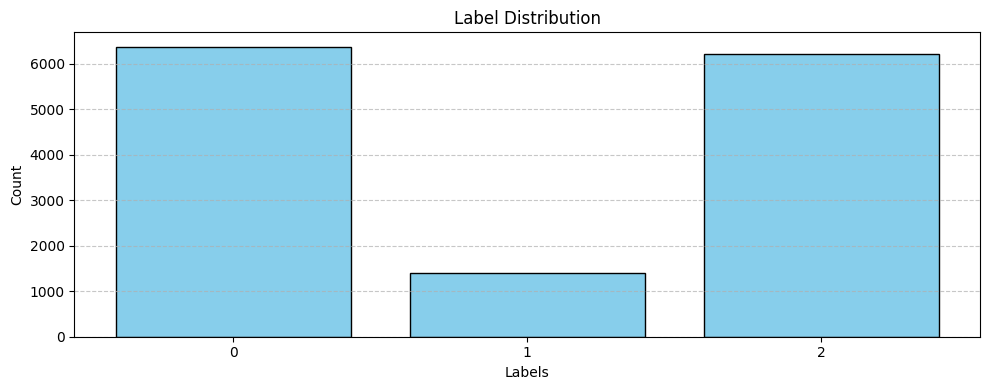


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


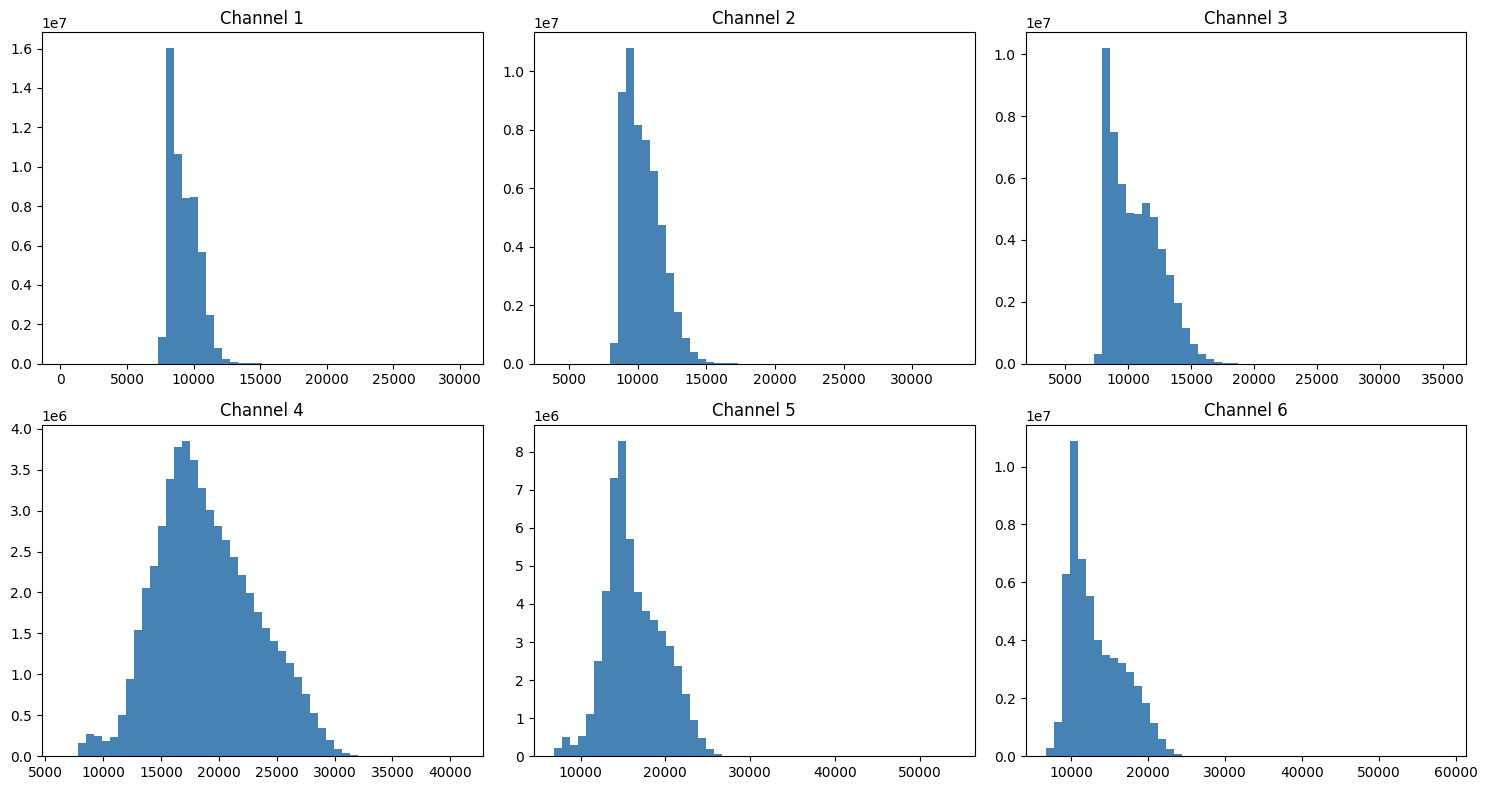

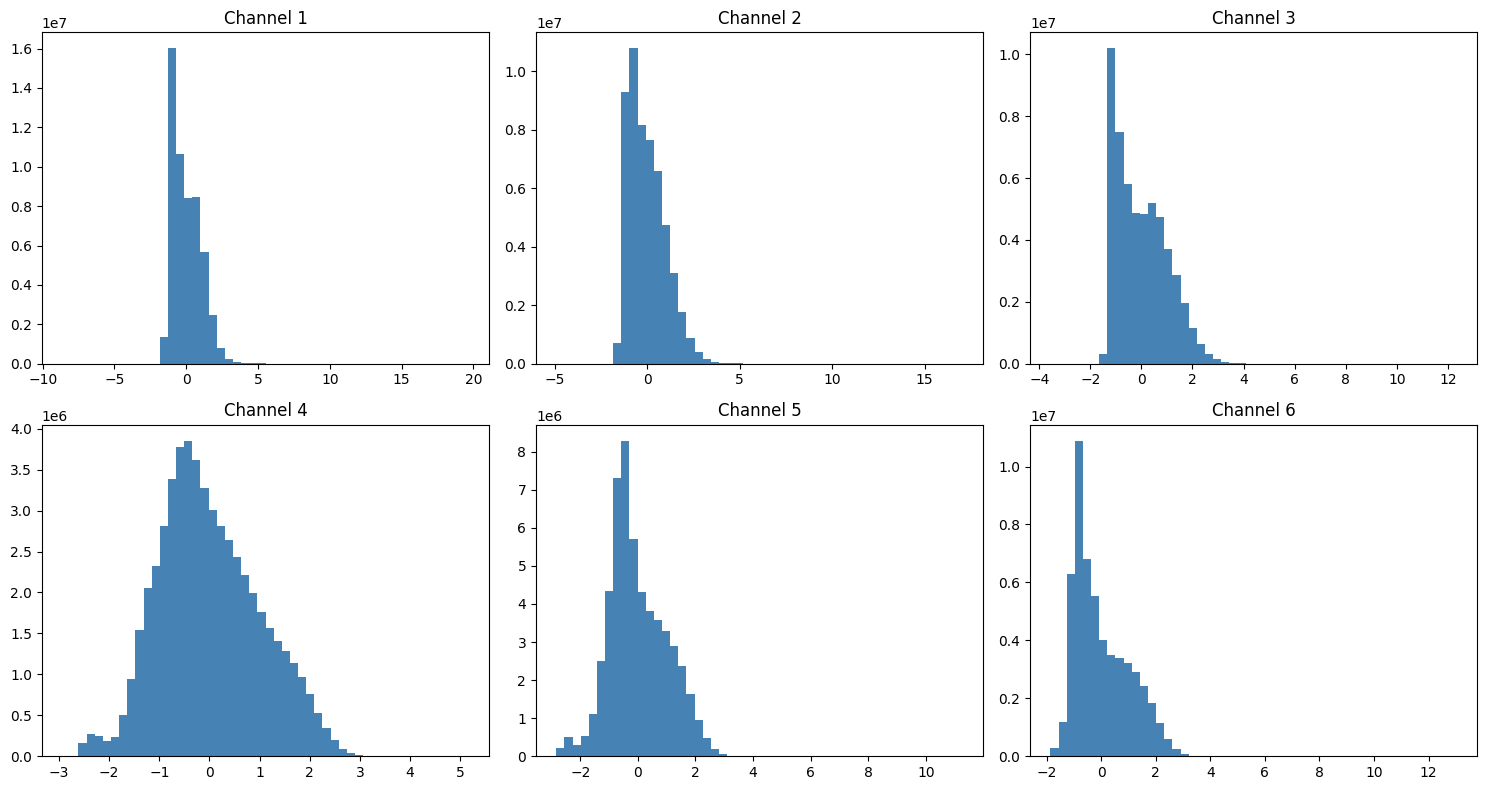



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


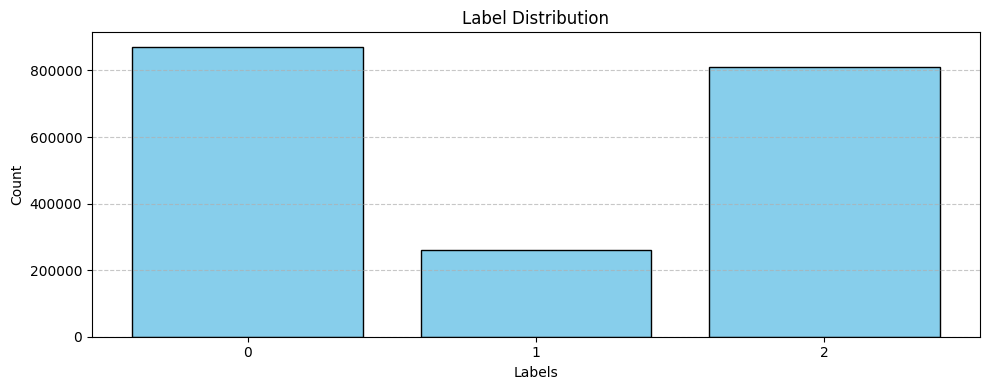

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.7320, 3.3050, 0.7511], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.8057 + 1e-07 * 2715661.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.29it/s]


Epoch [1/50] Train Loss: 1.4315, Train Acc: 0.4986 | Val Loss: 0.7326, Val Acc: 0.7966, F1: 0.8006, Kappa: 0.6691


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 0.8963 + 1e-07 * 2546236.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.47it/s]


Epoch [2/50] Train Loss: 1.1431, Train Acc: 0.5343 | Val Loss: 0.7188, Val Acc: 0.8306, F1: 0.8321, Kappa: 0.7251


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.86it/s]


Loss: 0.8220 + 1e-07 * 2383344.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.08it/s]


Epoch [3/50] Train Loss: 1.0940, Train Acc: 0.5493 | Val Loss: 0.6485, Val Acc: 0.8403, F1: 0.8379, Kappa: 0.7424


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 43.24it/s]


Loss: 0.8920 + 1e-07 * 2228155.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.27it/s]


Epoch [4/50] Train Loss: 1.0517, Train Acc: 0.5626 | Val Loss: 0.6250, Val Acc: 0.8376, F1: 0.8355, Kappa: 0.7377


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.8400 + 1e-07 * 2089758.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.08it/s]


Epoch [5/50] Train Loss: 1.0202, Train Acc: 0.5662 | Val Loss: 0.6142, Val Acc: 0.8564, F1: 0.8544, Kappa: 0.7670


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 43.22it/s]


Loss: 0.9695 + 1e-07 * 1966139.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.28it/s]


Epoch [6/50] Train Loss: 0.9932, Train Acc: 0.5694 | Val Loss: 0.5664, Val Acc: 0.8501, F1: 0.8478, Kappa: 0.7574


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 0.7389 + 1e-07 * 1853995.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.03it/s]


Epoch [7/50] Train Loss: 0.9753, Train Acc: 0.5749 | Val Loss: 0.5617, Val Acc: 0.8649, F1: 0.8627, Kappa: 0.7809


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.7016 + 1e-07 * 1753509.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.44it/s]


Epoch [8/50] Train Loss: 0.9610, Train Acc: 0.5775 | Val Loss: 0.5369, Val Acc: 0.8629, F1: 0.8613, Kappa: 0.7775


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 43.10it/s]


Loss: 0.8273 + 1e-07 * 1663881.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.80it/s]


Epoch [9/50] Train Loss: 0.9352, Train Acc: 0.5829 | Val Loss: 0.5284, Val Acc: 0.8691, F1: 0.8678, Kappa: 0.7873


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 43.05it/s]


Loss: 0.6879 + 1e-07 * 1585245.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.88it/s]


Epoch [10/50] Train Loss: 0.9177, Train Acc: 0.5912 | Val Loss: 0.5021, Val Acc: 0.8664, F1: 0.8653, Kappa: 0.7833


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.8922 + 1e-07 * 1515137.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.27it/s]


Epoch [11/50] Train Loss: 0.9089, Train Acc: 0.5943 | Val Loss: 0.4771, Val Acc: 0.8699, F1: 0.8658, Kappa: 0.7895


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.8328 + 1e-07 * 1451024.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.10it/s]


Epoch [12/50] Train Loss: 0.8922, Train Acc: 0.6009 | Val Loss: 0.4815, Val Acc: 0.8788, F1: 0.8773, Kappa: 0.8026


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.8257 + 1e-07 * 1393993.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.04it/s]


Epoch [13/50] Train Loss: 0.8887, Train Acc: 0.6003 | Val Loss: 0.4591, Val Acc: 0.8777, F1: 0.8741, Kappa: 0.8014


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 43.16it/s]


Loss: 0.6870 + 1e-07 * 1341278.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.61it/s]


Epoch [14/50] Train Loss: 0.8734, Train Acc: 0.6017 | Val Loss: 0.4716, Val Acc: 0.8819, F1: 0.8802, Kappa: 0.8075


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.7618 + 1e-07 * 1292913.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.97it/s]


Epoch [15/50] Train Loss: 0.8668, Train Acc: 0.6072 | Val Loss: 0.4423, Val Acc: 0.8679, F1: 0.8665, Kappa: 0.7857


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.7293 + 1e-07 * 1249803.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.19it/s]


Epoch [16/50] Train Loss: 0.8568, Train Acc: 0.6088 | Val Loss: 0.4452, Val Acc: 0.8695, F1: 0.8654, Kappa: 0.7886


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 43.15it/s]


Loss: 0.8732 + 1e-07 * 1211989.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.22it/s]


Epoch [17/50] Train Loss: 0.8505, Train Acc: 0.6159 | Val Loss: 0.4787, Val Acc: 0.8782, F1: 0.8732, Kappa: 0.8001


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.8466 + 1e-07 * 1177844.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.63it/s]


Epoch [18/50] Train Loss: 0.8482, Train Acc: 0.6176 | Val Loss: 0.4322, Val Acc: 0.8861, F1: 0.8831, Kappa: 0.8145


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.7083 + 1e-07 * 1147824.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.48it/s]


Epoch [19/50] Train Loss: 0.8372, Train Acc: 0.6143 | Val Loss: 0.4014, Val Acc: 0.8900, F1: 0.8894, Kappa: 0.8206


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 43.16it/s]


Loss: 0.6052 + 1e-07 * 1116919.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.30it/s]


Epoch [20/50] Train Loss: 0.8220, Train Acc: 0.6180 | Val Loss: 0.4319, Val Acc: 0.8751, F1: 0.8746, Kappa: 0.7964


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 43.13it/s]


Loss: 0.8232 + 1e-07 * 1090734.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.52it/s]


Epoch [21/50] Train Loss: 0.8263, Train Acc: 0.6203 | Val Loss: 0.3956, Val Acc: 0.8792, F1: 0.8752, Kappa: 0.8037


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 43.28it/s]


Loss: 0.7398 + 1e-07 * 1063890.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.96it/s]


Epoch [22/50] Train Loss: 0.8109, Train Acc: 0.6219 | Val Loss: 0.4040, Val Acc: 0.8839, F1: 0.8793, Kappa: 0.8114


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 42.99it/s]


Loss: 0.7856 + 1e-07 * 1040663.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.76it/s]


Epoch [23/50] Train Loss: 0.8136, Train Acc: 0.6212 | Val Loss: 0.4288, Val Acc: 0.8819, F1: 0.8821, Kappa: 0.8068


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 43.09it/s]


Loss: 0.6841 + 1e-07 * 1018262.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.21it/s]


Epoch [24/50] Train Loss: 0.8175, Train Acc: 0.6217 | Val Loss: 0.4020, Val Acc: 0.8842, F1: 0.8825, Kappa: 0.8116


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 43.09it/s]


Loss: 0.7181 + 1e-07 * 999171.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.68it/s]


Epoch [25/50] Train Loss: 0.8048, Train Acc: 0.6278 | Val Loss: 0.4143, Val Acc: 0.8829, F1: 0.8805, Kappa: 0.8091


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.5638 + 1e-07 * 982032.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.18it/s]


Epoch [26/50] Train Loss: 0.8032, Train Acc: 0.6265 | Val Loss: 0.3847, Val Acc: 0.8806, F1: 0.8764, Kappa: 0.8064


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 43.03it/s]


Loss: 0.7351 + 1e-07 * 964336.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.13it/s]


Epoch [27/50] Train Loss: 0.8010, Train Acc: 0.6222 | Val Loss: 0.3836, Val Acc: 0.8856, F1: 0.8837, Kappa: 0.8138


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 43.17it/s]


Loss: 0.7044 + 1e-07 * 948847.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.95it/s]


Epoch [28/50] Train Loss: 0.7855, Train Acc: 0.6348 | Val Loss: 0.4205, Val Acc: 0.8863, F1: 0.8837, Kappa: 0.8130


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.4001 + 1e-07 * 933558.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.93it/s]


Epoch [29/50] Train Loss: 0.7896, Train Acc: 0.6347 | Val Loss: 0.3963, Val Acc: 0.8889, F1: 0.8880, Kappa: 0.8186


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.60it/s]


Loss: 0.8119 + 1e-07 * 920003.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.75it/s]


Epoch [30/50] Train Loss: 0.7815, Train Acc: 0.6349 | Val Loss: 0.3708, Val Acc: 0.8842, F1: 0.8804, Kappa: 0.8118


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.6603 + 1e-07 * 907699.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.23it/s]


Epoch [31/50] Train Loss: 0.7768, Train Acc: 0.6385 | Val Loss: 0.3858, Val Acc: 0.8876, F1: 0.8823, Kappa: 0.8172


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.86it/s]


Loss: 0.5841 + 1e-07 * 895284.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.38it/s]


Epoch [32/50] Train Loss: 0.7761, Train Acc: 0.6373 | Val Loss: 0.3583, Val Acc: 0.8898, F1: 0.8873, Kappa: 0.8206


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 42.26it/s]


Loss: 0.7694 + 1e-07 * 883018.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.17it/s]


Epoch [33/50] Train Loss: 0.7623, Train Acc: 0.6430 | Val Loss: 0.3794, Val Acc: 0.8860, F1: 0.8814, Kappa: 0.8145


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.40it/s]


Loss: 0.8125 + 1e-07 * 873886.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.46it/s]


Epoch [34/50] Train Loss: 0.7757, Train Acc: 0.6362 | Val Loss: 0.3771, Val Acc: 0.8842, F1: 0.8826, Kappa: 0.8112


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.50it/s]


Loss: 0.7339 + 1e-07 * 863550.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.03it/s]


Epoch [35/50] Train Loss: 0.7692, Train Acc: 0.6407 | Val Loss: 0.3821, Val Acc: 0.8841, F1: 0.8813, Kappa: 0.8113


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.29it/s]


Loss: 0.5832 + 1e-07 * 853460.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.21it/s]


Epoch [36/50] Train Loss: 0.7668, Train Acc: 0.6379 | Val Loss: 0.3816, Val Acc: 0.8918, F1: 0.8922, Kappa: 0.8229


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.08it/s]


Loss: 0.6068 + 1e-07 * 847026.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.87it/s]


Epoch [37/50] Train Loss: 0.7666, Train Acc: 0.6422 | Val Loss: 0.3647, Val Acc: 0.8888, F1: 0.8897, Kappa: 0.8182


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.88it/s]


Loss: 0.8850 + 1e-07 * 838900.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.68it/s]


Epoch [38/50] Train Loss: 0.7515, Train Acc: 0.6453 | Val Loss: 0.3530, Val Acc: 0.8829, F1: 0.8784, Kappa: 0.8100


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 43.02it/s]


Loss: 0.8443 + 1e-07 * 831491.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.89it/s]


Epoch [39/50] Train Loss: 0.7569, Train Acc: 0.6455 | Val Loss: 0.3650, Val Acc: 0.8897, F1: 0.8871, Kappa: 0.8203


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.5081 + 1e-07 * 824633.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.82it/s]


Epoch [40/50] Train Loss: 0.7524, Train Acc: 0.6472 | Val Loss: 0.3726, Val Acc: 0.8840, F1: 0.8817, Kappa: 0.8111


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.7282 + 1e-07 * 818180.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.22it/s]


Epoch [41/50] Train Loss: 0.7539, Train Acc: 0.6451 | Val Loss: 0.3965, Val Acc: 0.8807, F1: 0.8760, Kappa: 0.8050


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 41.18it/s]


Loss: 0.5802 + 1e-07 * 812867.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.24it/s]


Epoch [42/50] Train Loss: 0.7568, Train Acc: 0.6454 | Val Loss: 0.3684, Val Acc: 0.8887, F1: 0.8863, Kappa: 0.8186


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 41.70it/s]


Loss: 0.5915 + 1e-07 * 805687.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.28it/s]


Epoch [43/50] Train Loss: 0.7436, Train Acc: 0.6503 | Val Loss: 0.3497, Val Acc: 0.8853, F1: 0.8821, Kappa: 0.8135


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.6803 + 1e-07 * 800483.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.35it/s]


Epoch [44/50] Train Loss: 0.7494, Train Acc: 0.6477 | Val Loss: 0.3930, Val Acc: 0.8800, F1: 0.8758, Kappa: 0.8036


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.7232 + 1e-07 * 795091.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.94it/s]


Epoch [45/50] Train Loss: 0.7359, Train Acc: 0.6517 | Val Loss: 0.3517, Val Acc: 0.8874, F1: 0.8869, Kappa: 0.8163


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 43.04it/s]


Loss: 0.9223 + 1e-07 * 790938.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.77it/s]


Epoch [46/50] Train Loss: 0.7420, Train Acc: 0.6465 | Val Loss: 0.4165, Val Acc: 0.8724, F1: 0.8706, Kappa: 0.7917


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 43.08it/s]


Loss: 0.5628 + 1e-07 * 786538.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.96it/s]


Epoch [47/50] Train Loss: 0.7434, Train Acc: 0.6494 | Val Loss: 0.3606, Val Acc: 0.8880, F1: 0.8847, Kappa: 0.8174


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.99it/s]


Loss: 0.9562 + 1e-07 * 780988.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.61it/s]


Epoch [48/50] Train Loss: 0.7349, Train Acc: 0.6535 | Val Loss: 0.3794, Val Acc: 0.8901, F1: 0.8878, Kappa: 0.8199


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 43.11it/s]


Loss: 0.5468 + 1e-07 * 778451.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.83it/s]


Epoch [49/50] Train Loss: 0.7380, Train Acc: 0.6513 | Val Loss: 0.3386, Val Acc: 0.8902, F1: 0.8862, Kappa: 0.8215


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.7225 + 1e-07 * 774782.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.91it/s]


Epoch [50/50] Train Loss: 0.7351, Train Acc: 0.6536 | Val Loss: 0.3893, Val Acc: 0.8752, F1: 0.8746, Kappa: 0.7964


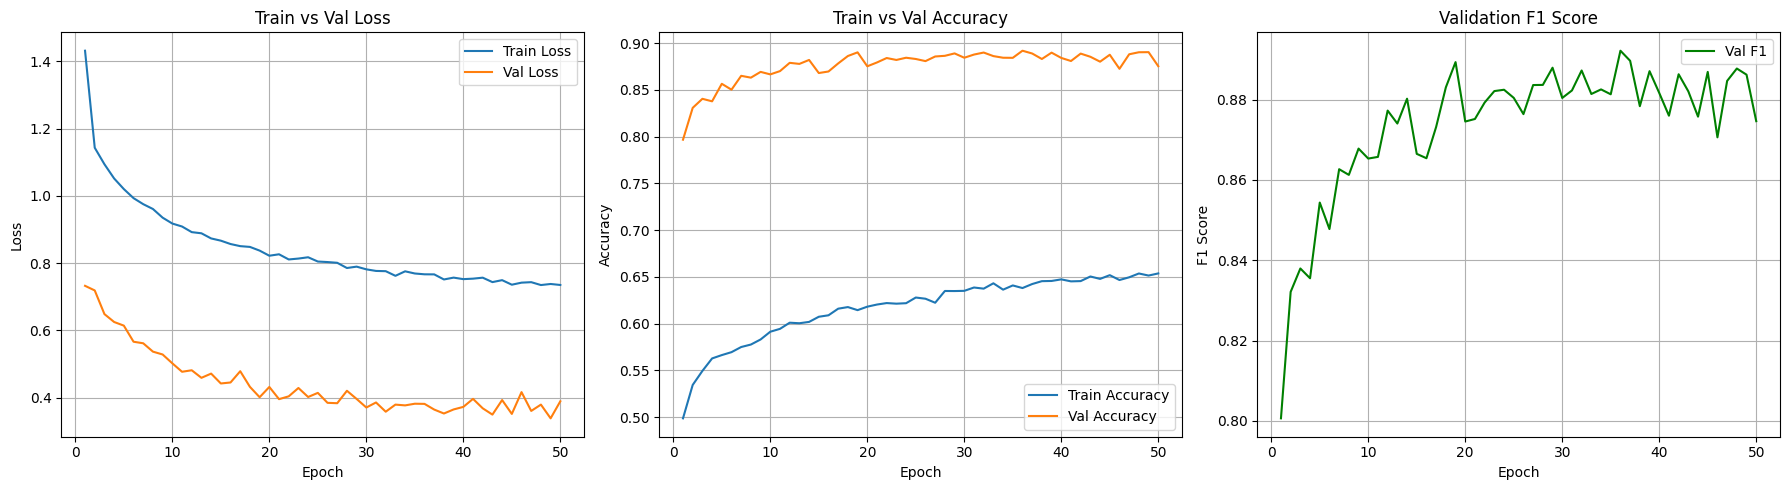


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:40<00:00, 137.15it/s]



====== Test Results ======
Overall Loss: 0.3883
Overall Accuracy: 0.8742
Cohen's Kappa: 0.7948
Per Class F1: [0.88041163 0.86854456 0.86925264]
Macro (Avg) F1: 0.8727


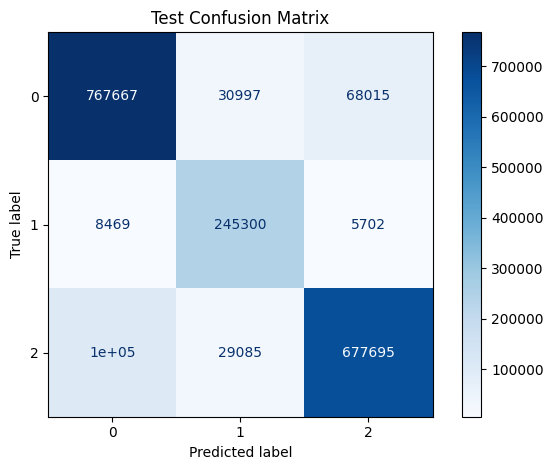

History Dumped in file /kaggle/working/deterministic_CNN_data_margin_history.json
Saved history of all files to true_BCNN_training_evaluation.xlsx


In [18]:
for name in file_names:
    print(f'\n\n====== Loading Data {name} ======')
    X_train, y_train = load_data(name)

    if X_train.shape[1:] == (6,28):
        X_train = X_train.transpose(0,2,1)
        
    print('Train Data: ', X_train.shape, y_train.shape)
    plot_input_dist(X_train)
    X_train = normalize(X_train)
    plot_input_dist(X_train)
    plot_label_dist(y_train)

    print(f'\n====== Loading Data Site {SITE} - {YEAR} ======')
    X_B2020, y_B2020 = load_data(X_B2020_path, y_B2020_path)
    print(f'Site {SITE} - {YEAR} Data: {X_B2020.shape}, {y_B2020.shape}')
    plot_input_dist(X_B2020)
    X_B2020 = normalize(X_B2020)
    plot_input_dist(X_B2020)
    plot_label_dist(y_B2020)

    # Data Split
    X_test, X_val, y_test, y_val = train_test_split(X_B2020, y_B2020, test_size=0.005, stratify=y_B2020, random_state=42)
    print(f'Val Data: ', X_val.shape, y_val.shape)
    print(f'Test Data: ', X_test.shape, y_test.shape)

    # Creating datasets and dataloaders
    train_dataset = Conv1dDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = Conv1dDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = Conv1dDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model Initialization
    model = BayesianCNN_FC(priors=PRIORS, num_classes=3, device=DEVICE).to(DEVICE)
    ckpt = torch.load('/kaggle/input/b_cnn/pytorch/default/1/BCNN.pth', map_location='cpu')
    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        state = ckpt['model_state_dict']
    else:
        state = ckpt
    
    new_state = {}
    for k, v in state.items():
        if k.startswith("_orig_mod."):
            new_state[k.replace("_orig_mod.", "")] = v
        else:
            new_state[k] = v
    model.load_state_dict(new_state, strict=True)

    # ===== Class weights =====
    all_labels = []
    for _, y_batch in train_dataloader:
        all_labels.append(y_batch.numpy())
    
    all_labels = np.concatenate(all_labels)
    classes = np.unique(all_labels)
    class_weights_np = compute_class_weight(class_weight='balanced',
                                            classes=classes, y=all_labels)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
    print("Class weights:", class_weights)

    print(f'\n====== Training the Model ======')
    train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s = train(model, train_dataset, train_dataloader, val_dataset, val_dataloader, class_weights, EPOCHS=EPOCHS, T=T)
    plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS)

    print(f'\n====== Testing the Model ======')
    loss, acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, class_weights=class_weights, T=T, device=DEVICE)

    # Printing
    print(f'\n====== Test Results ======')
    print(f'Overall Loss: {loss:.4f}')
    print(f'Overall Accuracy: {acc:.4f}')
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f'Per Class F1: {per_class_f1}')
    print(f"Macro (Avg) F1: {avg_f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Test Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Logging History
    history[name]['train_loss'] = train_losses
    history[name]['train_acc'] = train_accs
    history[name]['val_loss'] = val_losses
    history[name]['val_acc'] = val_accs
    history[name]['val_f1s'] = val_f1s
    history[name]['val_kappas'] = val_kappas
    history[name]['val_per_class_f1s'] = val_per_class_f1s
    
    history[name]['overall_loss'] = float(loss)
    history[name]['overall_acc'] = float(acc)
    history[name]['kappa'] = float(kappa)
    history[name]['per_class_f1'] = per_class_f1.tolist() if isinstance(per_class_f1, (np.ndarray, list)) else per_class_f1
    history[name]['avg_f1'] = float(avg_f1)
    history[name]['cm'] = cm.tolist() if hasattr(cm, "tolist") else cm

    # Dumping
    save_history(history[name], name)

    
# Saving the Results
save_results('true_BCNN_training_evaluation', history)

<hr>